<a href="https://colab.research.google.com/github/jungsunyoo/CSSG_LCM/blob/main/CSCG_Original_Jungsun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
from builtins import range
import numpy as np
import numba as nb
from tqdm import trange
import sys
import networkx as nx  # Import the networkx library
# from numba import jit
# import numpy as np
import matplotlib.pyplot as plt
import pdb

In [ ]:
from __future__ import print_function
from builtins import range
import numpy as np
import numba as nb
from tqdm import trange
import sys
import networkx as nx  # Import the networkx library
from numba import jit

def validate_seq(x, a, n_clones=None):
    """Validate an input sequence of observations x and actions a"""
    assert len(x) == len(a) > 0
    assert len(x.shape) == len(a.shape) == 1, "Flatten your array first"
    assert x.dtype == a.dtype == np.int64
    assert 0 <= x.min(), "Number of emissions inconsistent with training sequence"
    if n_clones is not None:
        assert len(n_clones.shape) == 1, "Flatten your array first"
        assert n_clones.dtype == np.int64
        assert all(
            [c > 0 for c in n_clones]
        ), "You can't provide zero clones for any emission"
        n_emissions = n_clones.shape[0]
        assert (
            x.max() < n_emissions
        ), "Number of emissions inconsistent with training sequence"


def datagen_structured_obs_room(
    room,
    start_r=None,
    start_c=None,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=10000,
    seed=42,
):
    """room is a 2d numpy array. inaccessible locations are marked by -1.
    start_r, start_c: starting locations

    In addition, there are invisible obstructions in the room
    which disallows certain actions from certain states.

    no_left:
    no_right:
    no_up:
    no_down:

    Each of the above are list of states from which the corresponding action is not allowed.

    """
    np.random.seed(seed)
    H, W = room.shape
    if start_r is None or start_c is None:
        start_r, start_c = np.random.randint(H), np.random.randint(W)

    actions = np.zeros(length, int)
    x = np.zeros(length, int)  # observations
    rc = np.zeros((length, 2), int)  # actual r&c

    r, c = start_r, start_c
    x[0] = room[r, c]
    rc[0] = r, c

    count = 0
    while count < length - 1:

        act_list = [0, 1, 2, 3]  # 0: left, 1: right, 2: up, 3: down
        if (r, c) in no_left:
            act_list.remove(0)
        if (r, c) in no_right:
            act_list.remove(1)
        if (r, c) in no_up:
            act_list.remove(2)
        if (r, c) in no_down:
            act_list.remove(3)

        a = np.random.choice(act_list)

        # Check for actions taking out of the matrix boundary.
        prev_r = r
        prev_c = c
        if a == 0 and 0 < c:
            c -= 1
        elif a == 1 and c < W - 1:
            c += 1
        elif a == 2 and 0 < r:
            r -= 1
        elif a == 3 and r < H - 1:
            r += 1

        # Check whether action is taking to inaccessible states.
        temp_x = room[r, c]
        if temp_x == -1:
            r = prev_r
            c = prev_c
            pass

        actions[count] = a
        x[count + 1] = room[r, c]
        rc[count + 1] = r, c
        count += 1

    return actions, x, rc


class CHMM(object):
    def __init__(self, n_clones, x, a, pseudocount=0.0, dtype=np.float32, seed=42):
        """Construct a CHMM objct. n_clones is an array where n_clones[i] is the
        number of clones assigned to observation i. x and a are the observation sequences
        and action sequences, respectively."""
        np.random.seed(seed)
        self.n_clones = n_clones
        validate_seq(x, a, self.n_clones)
        assert pseudocount >= 0.0, "The pseudocount should be positive"
        print("Average number of clones:", n_clones.mean())
        self.pseudocount = pseudocount
        self.dtype = dtype
        n_states = self.n_clones.sum()
        n_actions = a.max() + 1
        self.C = np.random.rand(n_actions, n_states, n_states).astype(dtype)
        self.Pi_x = np.ones(n_states) / n_states
        self.Pi_a = np.ones(n_actions) / n_actions
        self.update_T()

    def update_T(self):
        """Update the transition matrix given the accumulated counts matrix."""
        self.T = self.C + self.pseudocount
        norm = self.T.sum(2, keepdims=True)
        norm[norm == 0] = 1
        self.T /= norm

    # def update_T(self):
    #     self.T = self.C + self.pseudocount
    #     norm = self.T.sum(2, keepdims=True)  # old model (conditional on actions)
    #     norm[norm == 0] = 1
    #     self.T /= norm
    #     norm = self.T.sum((0, 2), keepdims=True)  # new model (generates actions too)
    #     norm[norm == 0] = 1
    #     self.T /= norm

    def update_E(self, CE):
        """Update the emission matrix."""
        E = CE + self.pseudocount
        norm = E.sum(1, keepdims=True)
        norm[norm == 0] = 1
        E /= norm
        return E

    def bps(self, x, a):
        """Compute the log likelihood (log base 2) of a sequence of observations and actions."""
        validate_seq(x, a, self.n_clones)
        log2_lik = forward(self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a)[0]
        return -log2_lik

    def bpsE(self, E, x, a):
        """Compute the log likelihood using an alternate emission matrix."""
        validate_seq(x, a, self.n_clones)
        log2_lik = forwardE(
            self.T.transpose(0, 2, 1), E, self.Pi_x, self.n_clones, x, a
        )
        return -log2_lik

    def bpsV(self, x, a):
        validate_seq(x, a, self.n_clones)
        log2_lik = forward_mp(
            self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a
        )[0]
        return -log2_lik

    def decode(self, x, a):
        """Compute the MAP assignment of latent variables using max-product message passing."""
        log2_lik, mess_fwd = forward_mp(
            self.T.transpose(0, 2, 1),
            self.Pi_x,
            self.n_clones,
            x,
            a,
            store_messages=True,
        )
        states, ginis = backtrace(self.T, self.n_clones, x, a, mess_fwd)
        # print(mess_fwd)
        return -log2_lik, states, ginis

    def decodeE(self, E, x, a):
        """Compute the MAP assignment of latent variables using max-product message passing
        with an alternative emission matrix."""
        log2_lik, mess_fwd = forwardE_mp(
            self.T.transpose(0, 2, 1),
            E,
            self.Pi_x,
            self.n_clones,
            x,
            a,
            store_messages=True,
        )
        states = backtraceE(self.T, E, self.n_clones, x, a, mess_fwd)
        return -log2_lik, states

    def learn_em_T(self, x, a, n_iter=100, term_early=True):
        """Run EM training, keeping E deterministic and fixed, learning T"""
        sys.stdout.flush()
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E
            log2_lik, mess_fwd = forward(
                self.T.transpose(0, 2, 1),
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            mess_bwd = backward(self.T, self.n_clones, x, a)
            updateC(self.C, self.T, self.n_clones, mess_fwd, mess_bwd, x, a)
            # M
            self.update_T()
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                if term_early:
                    break
            log2_lik_old = log2_lik.mean()
            # print(log2_lik_old)
        # JY added for plotting learning curve
        plt.plot(convergence, label='Training Loss')
        plt.title('Learning Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
        return convergence

    def learn_viterbi_T(self, x, a, n_iter=100):
        """Run Viterbi training, keeping E deterministic and fixed, learning T"""
        sys.stdout.flush()
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E
            log2_lik, mess_fwd = forward_mp(
                self.T.transpose(0, 2, 1),
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            states,_ = backtrace(self.T, self.n_clones, x, a, mess_fwd)
            self.C[:] = 0
            for t in range(1, len(x)):
                aij, i, j = (
                    a[t - 1],
                    states[t - 1],
                    states[t],
                )  # at time t-1 -> t we go from observation i to observation j
                self.C[aij, i, j] += 1.0
            # M
            self.update_T()

            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                break
            log2_lik_old = log2_lik.mean()
        return convergence

    def learn_em_E(self, x, a, n_iter=100, pseudocount_extra=1e-20):
        """Run Viterbi training, keeping T fixed, learning E"""
        sys.stdout.flush()
        n_emissions, n_states = len(self.n_clones), self.n_clones.sum()
        CE = np.ones((n_states, n_emissions), self.dtype)
        E = self.update_E(CE + pseudocount_extra)
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E
            log2_lik, mess_fwd = forwardE(
                self.T.transpose(0, 2, 1),
                E,
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            mess_bwd = backwardE(self.T, E, self.n_clones, x, a)
            updateCE(CE, E, self.n_clones, mess_fwd, mess_bwd, x, a)
            # M
            E = self.update_E(CE + pseudocount_extra)
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                break
            log2_lik_old = log2_lik.mean()
        return convergence, E

    def sample(self, length):
        """Sample from the CHMM."""
        assert length > 0
        state_loc = np.hstack(([0], self.n_clones)).cumsum(0)
        sample_x = np.zeros(length, dtype=np.int64)
        sample_a = np.random.choice(len(self.Pi_a), size=length, p=self.Pi_a)

        # Sample
        p_h = self.Pi_x
        for t in range(length):
            h = np.random.choice(len(p_h), p=p_h)
            sample_x[t] = np.digitize(h, state_loc) - 1
            p_h = self.T[sample_a[t], h]
        return sample_x, sample_a

    def sample_sym(self, sym, length):
        """Sample from the CHMM conditioning on an inital observation."""
        # Prepare structures
        assert length > 0
        state_loc = np.hstack(([0], self.n_clones)).cumsum(0)

        seq = [sym]

        alpha = np.ones(self.n_clones[sym])
        alpha /= alpha.sum()

        for _ in range(length):
            obs_tm1 = seq[-1]
            T_weighted = self.T.sum(0)

            long_alpha = np.dot(
                alpha, T_weighted[state_loc[obs_tm1] : state_loc[obs_tm1 + 1], :]
            )
            long_alpha /= long_alpha.sum()
            idx = np.random.choice(np.arange(self.n_clones.sum()), p=long_alpha)

            sym = np.digitize(idx, state_loc) - 1
            seq.append(sym)

            temp_alpha = long_alpha[state_loc[sym] : state_loc[sym + 1]]
            temp_alpha /= temp_alpha.sum()
            alpha = temp_alpha

        return seq

    def bridge(self, state1, state2, max_steps=100):
        Pi_x = np.zeros(self.n_clones.sum(), dtype=self.dtype)
        Pi_x[state1] = 1
        log2_lik, mess_fwd = forward_mp_all(
            self.T.transpose(0, 2, 1), Pi_x, self.Pi_a, self.n_clones, state2, max_steps
        )
        s_a = backtrace_all(self.T, self.Pi_a, self.n_clones, mess_fwd, state2)
        return s_a


def updateCE(CE, E, n_clones, mess_fwd, mess_bwd, x, a):
    timesteps = len(x)
    gamma = mess_fwd * mess_bwd
    norm = gamma.sum(1, keepdims=True)
    norm[norm == 0] = 1
    gamma /= norm
    CE[:] = 0
    for t in range(timesteps):
        CE[:, x[t]] += gamma[t]


def forwardE(T_tr, E, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    message = Pi * E[:, j]
    p_obs = message.sum()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
        mess_fwd[t] = message
    for t in range(1, x.shape[0]):
        aij, j = (
            a[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        message = T_tr[aij].dot(message)
        message *= E[:, j]
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_fwd[t] = message
    if store_messages:
        return log2_lik, mess_fwd
    else:
        return log2_lik


def backwardE(T, E, n_clones, x, a):
    """Compute backward messages."""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T.dtype.type

    # backward pass
    t = x.shape[0] - 1
    message = np.ones(E.shape[0], dtype)
    message /= message.sum()
    mess_bwd = np.empty((len(x), E.shape[0]), dtype=dtype)
    mess_bwd[t] = message
    for t in range(x.shape[0] - 2, -1, -1):
        aij, j = (
            a[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        message = T[aij].dot(message * E[:, j])
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        mess_bwd[t] = message
    return mess_bwd


@nb.njit
def updateC(C, T, n_clones, mess_fwd, mess_bwd, x, a):
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    timesteps = len(x)
    C[:] = 0
    for t in range(1, timesteps):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (tm1_start, tm1_stop), (t_start, t_stop) = (
            mess_loc[t - 1 : t + 1],
            mess_loc[t : t + 2],
        )
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        q = (
            mess_fwd[tm1_start:tm1_stop].reshape(-1, 1)
            * T[aij, i_start:i_stop, j_start:j_stop]
            * mess_bwd[t_start:t_stop].reshape(1, -1)
        )
        q /= q.sum()
        C[aij, i_start:i_stop, j_start:j_stop] += q


@nb.njit
def forward(T_tr, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    j_start, j_stop = state_loc[j : j + 2]
    message = Pi[j_start:j_stop].copy().astype(dtype)
    p_obs = message.sum()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_loc = np.hstack(
            (np.array([0], dtype=n_clones.dtype), n_clones[x])
        ).cumsum()
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[t : t + 2]
        mess_fwd[t_start:t_stop] = message
    else:
        mess_fwd = None

    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        message = np.ascontiguousarray(T_tr[aij, j_start:j_stop, i_start:i_stop]).dot(
            message
        )
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            t_start, t_stop = mess_loc[t : t + 2]
            mess_fwd[t_start:t_stop] = message
    return log2_lik, mess_fwd


@nb.njit
def backward(T, n_clones, x, a):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T.dtype.type

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    message = np.ones(n_clones[i], dtype) / n_clones[i]
    message /= message.sum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    mess_bwd = np.empty(mess_loc[-1], dtype)
    t_start, t_stop = mess_loc[t : t + 2]
    mess_bwd[t_start:t_stop] = message
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        message = np.ascontiguousarray(T[aij, i_start:i_stop, j_start:j_stop]).dot(
            message
        )
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        t_start, t_stop = mess_loc[t : t + 2]
        mess_bwd[t_start:t_stop] = message
    return mess_bwd


@nb.njit
def forward_mp(T_tr, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    j_start, j_stop = state_loc[j : j + 2]
    message = Pi[j_start:j_stop].copy().astype(dtype)
    p_obs = message.max()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_loc = np.hstack(
            (np.array([0], dtype=n_clones.dtype), n_clones[x])
        ).cumsum()
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[t : t + 2]
        mess_fwd[t_start:t_stop] = message
    else:
        mess_fwd = None

    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        new_message = np.zeros(j_stop - j_start, dtype=dtype)
        for d in range(len(new_message)):
            new_message[d] = (T_tr[aij, j_start + d, i_start:i_stop] * message).max()
        message = new_message
        p_obs = message.max()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            t_start, t_stop = mess_loc[t : t + 2]
            mess_fwd[t_start:t_stop] = message
    return log2_lik, mess_fwd


@nb.njit
def rargmax(x):
    # return x.argmax()  # <- favors clustering towards smaller state numbers
    return np.random.choice((x == x.max()).nonzero()[0])


@nb.njit
def backtrace(T, n_clones, x, a, mess_fwd):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    code = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    t_start, t_stop = mess_loc[t : t + 2]
    belief = mess_fwd[t_start:t_stop]
    code[t] = rargmax(belief)
    ginis = []
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), j_start = state_loc[i : i + 2], state_loc[j]
        t_start, t_stop = mess_loc[t : t + 2]
        belief = (
            mess_fwd[t_start:t_stop] * T[aij, i_start:i_stop, j_start + code[t + 1]]
        )
        # JY added to calculate the distribution of beliefs:
        gini = gini_coefficient(belief)

        code[t] = rargmax(belief)
        ginis.append(gini)
    states = state_loc[x] + code
    return states, ginis


def backtraceE(T, E, n_clones, x, a, mess_fwd):
    """Compute backward messages."""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    states = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    belief = mess_fwd[t]
    states[t] = rargmax(belief)
    for t in range(x.shape[0] - 2, -1, -1):
        aij = a[t]  # at time t -> t+1 we go from observation i to observation j
        belief = mess_fwd[t] * T[aij, :, states[t + 1]]
        states[t] = rargmax(belief)
    return states


def forwardE_mp(T_tr, E, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    message = Pi * E[:, j]
    p_obs = message.max()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
        mess_fwd[t] = message
    for t in range(1, x.shape[0]):
        aij, j = (
            a[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        message = (T_tr[aij] * message.reshape(1, -1)).max(1)
        message *= E[:, j]
        p_obs = message.max()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_fwd[t] = message
    if store_messages:
        return log2_lik, mess_fwd
    else:
        return log2_lik


def forward_mp_all(T_tr, Pi_x, Pi_a, n_clones, target_state, max_steps):
    """Log-probability of a sequence, and optionally, messages"""
    # forward pass
    t, log2_lik = 0, []
    message = Pi_x
    p_obs = message.max()
    assert p_obs > 0
    message /= p_obs
    log2_lik.append(np.log2(p_obs))
    mess_fwd = []
    mess_fwd.append(message)
    T_tr_maxa = (T_tr * Pi_a.reshape(-1, 1, 1)).max(0)
    for t in range(1, max_steps):
        message = (T_tr_maxa * message.reshape(1, -1)).max(1)
        p_obs = message.max()
        assert p_obs > 0
        message /= p_obs
        log2_lik.append(np.log2(p_obs))
        mess_fwd.append(message)
        if message[target_state] > 0:
            break
    else:
        assert False, "Unable to find a bridging path"
    return np.array(log2_lik), np.array(mess_fwd)


def backtrace_all(T, Pi_a, n_clones, mess_fwd, target_state):
    """Compute backward messages."""
    states = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    actions = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    n_states = T.shape[1]
    # backward pass
    t = mess_fwd.shape[0] - 1
    actions[t], states[t] = (
        -1,
        target_state,
    )  # last actions is irrelevant, use an invalid value
    for t in range(mess_fwd.shape[0] - 2, -1, -1):
        belief = (
            mess_fwd[t].reshape(1, -1) * T[:, :, states[t + 1]] * Pi_a.reshape(-1, 1)
        )
        a_s = rargmax(belief.flatten())
        actions[t], states[t] = a_s // n_states, a_s % n_states
    return actions, states

@nb.njit
def gini_coefficient(values):
    """
    Calculate the Gini coefficient of a numpy array.

    Parameters:
    - values: a list or numpy array of values.

    Returns:
    - The Gini coefficient as a float.
    """
    # First we sort the array because the Gini coefficient formula assumes the array is sorted
    values = np.sort(values)
    # Calculate the cumulative sum of the sorted array
    cumsum = np.cumsum(values)
    # Calculate the Gini coefficient using the alternative formula
    n = len(values)
    gini = (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n
    return gini

In [ ]:
# sys.path.append('naturecomm_cscg')

!pip install cairocffi
!pip install python-igraph==0.9.8

import numpy as np
# from chmm_actions import CHMM, forwardE, datagen_structured_obs_room
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 460.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.8 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.9.8-py3-none-any.whl size=9063 sha256=05b6ed615a86bf9a1c69363f0dec5c4c488cf415e5be463f94356343388084aa
  Stored in directory: /root/.cache/pip/wheels/90/a0/98/80ea8eb9e079b4723cdb5a7c86e94506e54d1823fde8ffb775
Successfully built python-igraph


In [ ]:
import numpy as np

def generate_custom_colors(num_unique_observations):
    # Define a fixed set of custom colors as RGB values
    predefined_colors = np.array([
        [214, 214, 214],
        [85, 35, 157],
        [253, 252, 144],
        [114, 245, 144],
        [151, 38, 20],
        [239, 142, 192],
        [214, 134, 48],
        [140, 194, 250],
        [72, 160, 162],
    ])

    # If the number of unique observations is greater than the number of predefined colors,
    # cycle through the predefined colors to ensure enough colors are available
    if num_unique_observations > len(predefined_colors):
        extra_colors_needed = num_unique_observations - len(predefined_colors)
        additional_colors = np.tile(predefined_colors, (extra_colors_needed // len(predefined_colors) + 1, 1))
        custom_colors = np.vstack((predefined_colors, additional_colors))[:num_unique_observations]
    else:
        custom_colors = predefined_colors[:num_unique_observations]

    return custom_colors


In [ ]:
## A Few utility functions

def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out, v

def plot_graph_infomap(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    comms = g.community_infomap()
    print(len(comms))

    out = igraph.plot(
        comms,
        output_file,
        layout=g.layout("kamada_kawai"),
        mark_groups=True,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out

def plot_graph_modularity(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())

    # Convert the directed graph to an undirected graph
    g = g.as_undirected()

    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    # comms = g.community_infomap()

    # print(len(comms))
    # Detect communities using the Louvain method
    communities = g.community_multilevel()
    print(communities)
    modularity_score = g.modularity(communities)
    print("Modularity Score:", np.round(modularity_score,2))
    # Optionally, visualize the graph with its communities
    out = igraph.plot(communities, output_file, layout=g.layout("kamada_kawai"),
                      mark_groups=True, vertex_label=v, vertex_size=vertex_size, margin=50,)
    # out = igraph.plot(
    #     comms,
    #     output_file,
    #     layout=g.layout("kamada_kawai"),
    #     mark_groups=True,
    #     vertex_label=v,
    #     vertex_size=vertex_size,
    #     margin=50,
    # )

    return out, modularity_score


def get_mess_fwd(chmm, x, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    T = T.mean(0, keepdims=True)
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, x * 0, store_messages=True
    )
    return mess_fwd


def place_field(mess_fwd, rc, clone):
    assert mess_fwd.shape[0] == rc.shape[0] and clone < mess_fwd.shape[1]
    field = np.zeros(rc.max(0) + 1)
    count = np.zeros(rc.max(0) + 1, int)
    for t in range(mess_fwd.shape[0]):
        r, c = rc[t]
        field[r, c] += mess_fwd[t, clone]
        count[r, c] += 1
    count[count == 0] = 1
    return field / count



# # JY added for plotting learning curves
# def plot_learning_curve(losses):
#   plt.plot(losses, label='Training Loss')


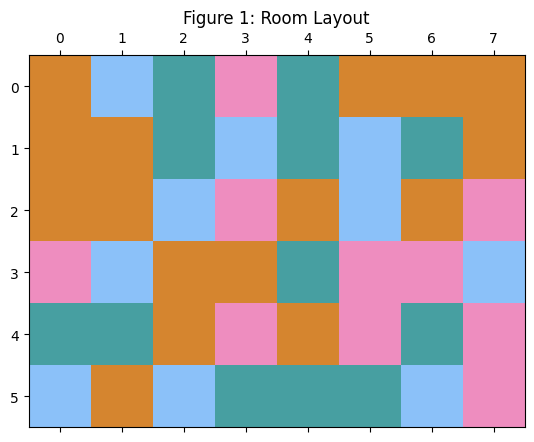

In [ ]:
# room = np.array(
#     [
#         [1, 2, 3, 0, 3,],
#         [1, 1, 3, 2, 3,],
#         [1, 1, 2, 0, 1,],
#         [0, 2, 1, 1, 3,],
#         [3, 3, 1, 0, 1,],
#         [2, 1, 2, 3, 3,],
#     ]
# )

# Uncomment this for generating data from a bigger room. Will take longer to train.

room = np.array(
    [
        [1, 2, 3, 0, 3, 1, 1, 1],
        [1, 1, 3, 2, 3, 2, 3, 1],
        [1, 1, 2, 0, 1, 2, 1, 0],
        [0, 2, 1, 1, 3, 0, 0, 2],
        [3, 3, 1, 0, 1, 0, 3, 0],
        [2, 1, 2, 3, 3, 3, 2, 0],
    ]
)


# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors[-4:])
plt.matshow(room, cmap=cmap)
plt.title('Figure 1: Room Layout')
plt.savefig("figures/rectangular_room_layout.pdf")

In [ ]:
n_clones

array([70, 70, 70, 70])

In [ ]:
# Consolidate learning. Takes a few seconds
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

In [ ]:
# Visualize the learned, consolidated CSCG for the room.

graph = plot_graph(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf", cmap=cmap
)
graph

# Look for the correspondence between the graph and the original layout of the rooom in Figure 1
# Node colors correspond to the observations from the room. Node numbers are the clone/neuron numbers.

In [ ]:
from IPython.display import display, Image
import igraph

Average number of clones: 10.0


 13%|█▎        | 128/1000 [00:04<00:33, 26.14it/s, train_bps=0.251]


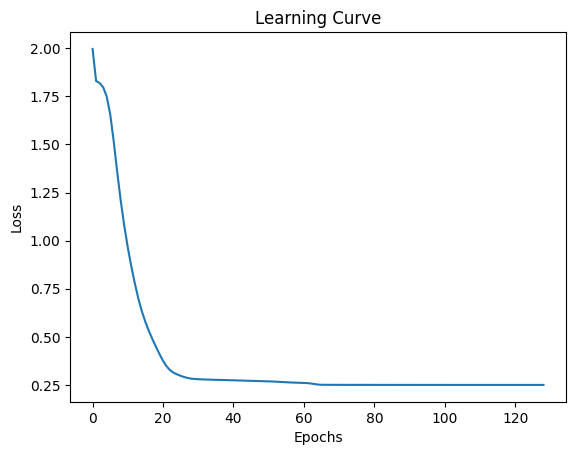

  2%|▏         | 2/100 [00:01<01:37,  1.01it/s, train_bps=0.263]

Ground truth number of nodes: 48, number of nodes recovered 39


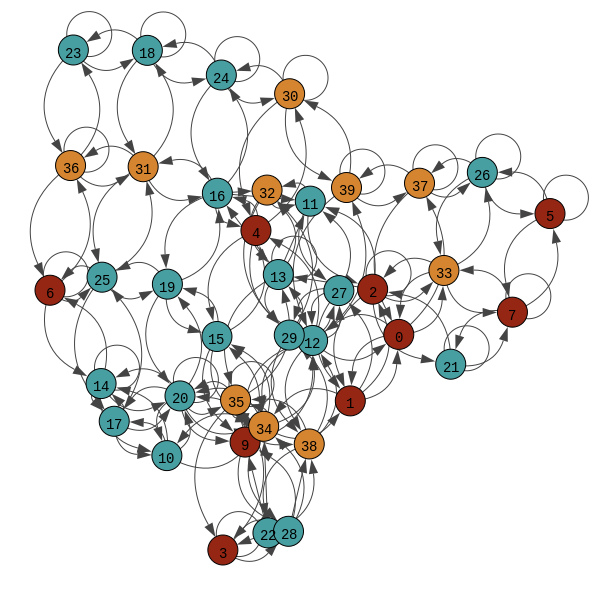

Average number of clones: 60.0


 17%|█▋        | 166/1000 [01:40<08:23,  1.66it/s, train_bps=0.0276]


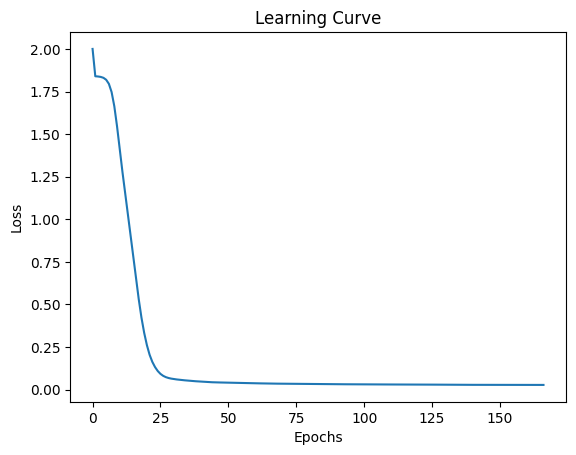

  2%|▏         | 2/100 [00:00<00:48,  2.03it/s, train_bps=0.00158]

Ground truth number of nodes: 48, number of nodes recovered 48


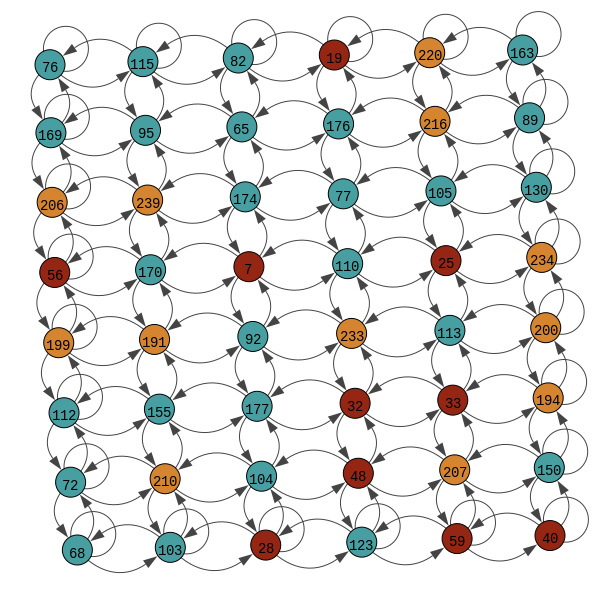

Average number of clones: 110.0


 10%|█         | 101/1000 [02:18<20:36,  1.38s/it, train_bps=0.0626]


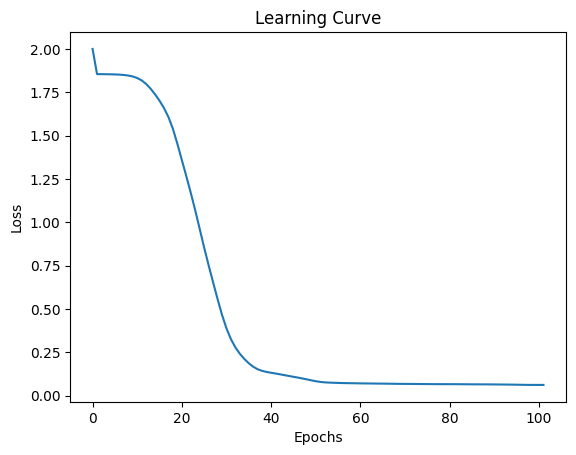

  2%|▏         | 2/100 [00:00<00:35,  2.75it/s, train_bps=0.0164]


Ground truth number of nodes: 48, number of nodes recovered 48


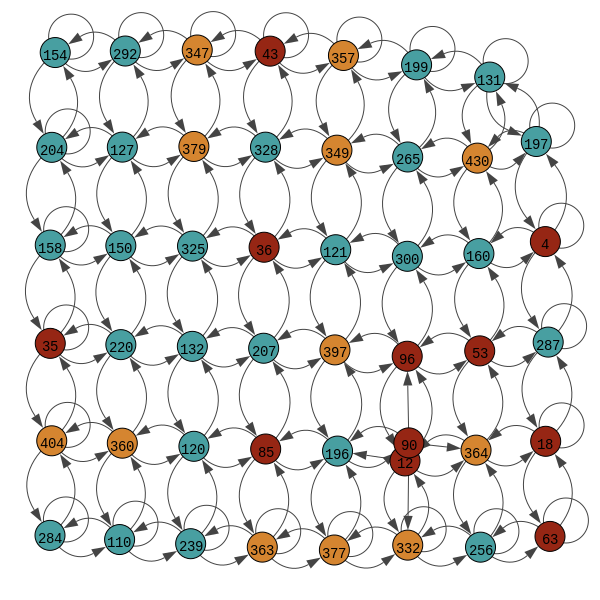

Average number of clones: 160.0


  0%|          | 3/1000 [00:09<55:15,  3.33s/it, train_bps=1.87]


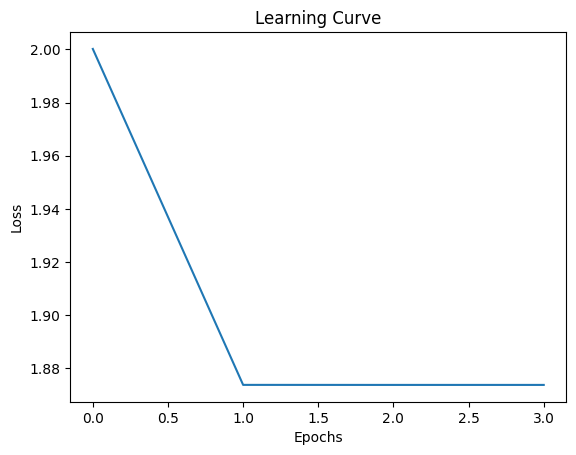

  6%|▌         | 6/100 [00:06<01:44,  1.12s/it, train_bps=1.16]


Ground truth number of nodes: 48, number of nodes recovered 474


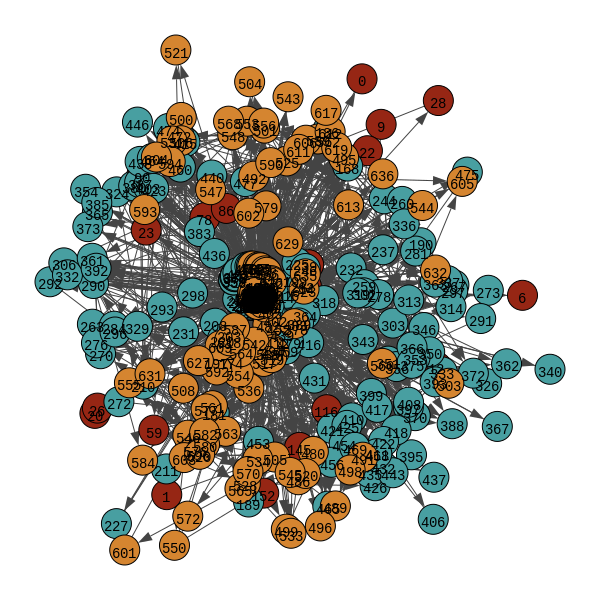

Average number of clones: 210.0


  0%|          | 2/1000 [00:10<1:24:13,  5.06s/it, train_bps=1.89]


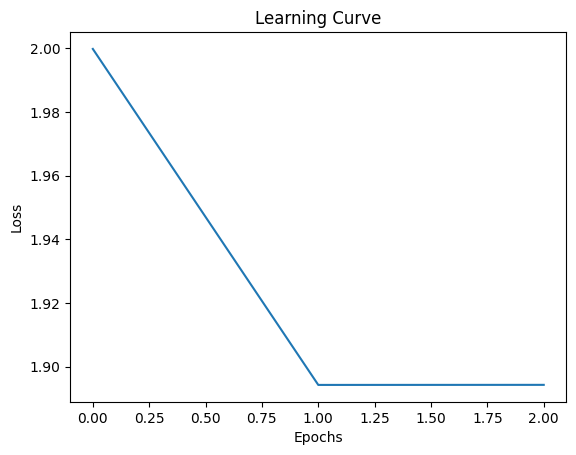

  6%|▌         | 6/100 [00:08<02:11,  1.40s/it, train_bps=1.17]


Ground truth number of nodes: 48, number of nodes recovered 627


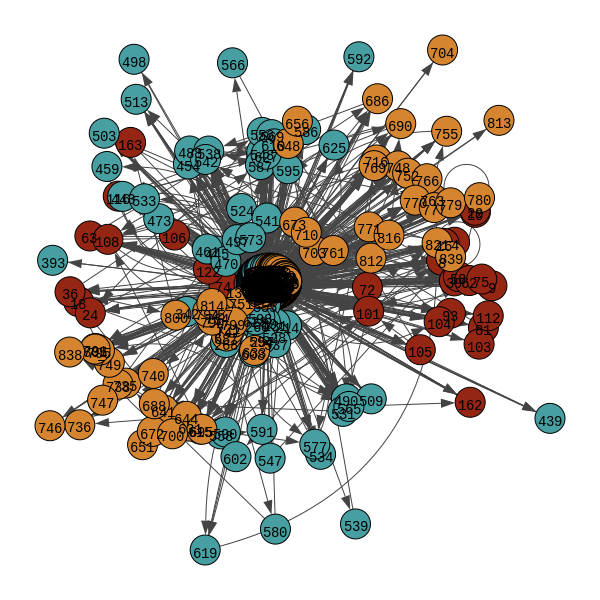

In [ ]:
# Generate data from the room and train a CSCG. Takes about a minute
clones = np.arange(10, 220, 50)
# clones=[70]
# nclone = 70
n_emissions = room.max() + 1

a, x, rc = datagen_structured_obs_room(room, length=5000)     #Use length=50000 for bigger room
for nclone in clones:
  n_clones = np.ones(n_emissions, dtype=np.int64) * nclone
  chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
  progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training   use n_iter=1000 for better training
  # progression = chmm.learn_em_E(x, a, n_iter=1000)  # Training   use n_iter=1000 for better training

  # Consolidate learning. Takes a few seconds
  chmm.pseudocount = 0.0
  chmm.learn_viterbi_T(x, a, n_iter=100)

  # graph = plot_graph(
  #     chmm, x, a, output_file="figures/rectangular_room_graph.pdf", cmap=cmap
  # )
  # graph

  # cmap = colors.ListedColormap(custom_colors[arr])

  temp_output_file = f"rectangular_room_graph_large_num_clones_{nclone}.png"  # Temporary file for each clone
  graph, v = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)
  print('Ground truth number of nodes: {}, number of nodes recovered {}'.format(len(room.flatten()), len(v)))
  # Display the image inline
  display(Image(filename=temp_output_file))


In [ ]:
chmm.decode(x,a)[2]

In [ ]:
# return -log2_lik, states, mess_fwd
ginis = chmm.decode(x,a)[1]
np.shape(ginis)

In [ ]:
np.unique(ginis)


In [ ]:
plt.hist(ginis)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random

# Function to create a lattice graph with variable nodes, observations, and aliased states
def create_modular_graph_varied(num_nodes=15, num_observations=10000, num_aliased_states=10, num_modules=3):
    if num_nodes < 4:
        raise ValueError("num_nodes must be at least 4 to allow for meaningful connectivity.")

    if num_nodes < num_modules:
        raise ValueError("Number of nodes must be at least equal to the number of modules to form a meaningful structure.")

    # Initialize the adjacency matrix
    T = np.zeros((num_nodes, num_nodes))

    # Calculate the size of each module
    module_size = num_nodes // num_modules

    for module_index in range(num_modules):
        module_start = module_index * module_size
        # For the last module, extend to the end of the node list
        module_end = module_start + module_size if module_index < num_modules - 1 else num_nodes

        # Fully connect nodes within the module
        for i in range(module_start, module_end):
            for j in range(module_start, module_end):
                if i != j:
                    T[i, j] = 1.0
    # Optionally, add sparse inter-module connections
    # Example: Connecting last node of one module to first node of the next module
    for module_index in range(num_modules - 1):
        module_end = (module_index + 1) * module_size - 1
        next_module_start = (module_end + 1) % num_nodes
        T[module_end, next_module_start] = 1.0
        T[next_module_start, module_end] = 1.0
    # connect first and last module
    T[0, num_nodes-1] = 1.0
    T[num_nodes-1,0] = 1.0



    # Generate observations based on random walks on the lattice graph
    states = [np.random.choice(range(num_nodes))]  # Start from a random state
    for _ in range(1, num_observations):
        current_state = states[-1]
        possible_next_states = np.where(T[current_state, :] > 0)[0]
        next_state = np.random.choice(possible_next_states)
        states.append(next_state)


    # Map states to observations with aliasing
    if num_aliased_states > num_nodes or num_aliased_states < 1:
        raise ValueError("num_aliased_states must be between 1 and the number of nodes.")


    unique_obs = np.arange(num_nodes - num_aliased_states)
    for n in range(num_aliased_states):
      unique_obs = np.append(unique_obs,random.choice(unique_obs))
    state_to_obs = unique_obs # Aliasing version

    # Create observation data
    x = state_to_obs[states]

    plt.matshow(T)
    plt.show()

    return x

# Function to create a lattice graph with variable nodes, observations, and aliased states
def create_lattice_graph_varied(num_nodes=15, num_observations=10000, num_aliased_states=10):
    if num_nodes < 4:
        raise ValueError("num_nodes must be at least 4 to allow for meaningful connectivity.")

    # Initialize the adjacency matrix
    T = np.zeros((num_nodes, num_nodes))

    # Connect each node to its immediate and second-order neighbors with wrapping
    for i in range(num_nodes):
        for offset in [-2, -1, 1, 2]:  # Immediate and second-order neighbors
            j = (i + offset) % num_nodes
            T[i, j] = 1.0

    # Generate observations based on random walks on the lattice graph
    states = [np.random.choice(range(num_nodes))]  # Start from a random state
    for _ in range(1, num_observations):
        current_state = states[-1]
        possible_next_states = np.where(T[current_state, :] > 0)[0]
        next_state = np.random.choice(possible_next_states)
        states.append(next_state)


    # Map states to observations with aliasing
    if num_aliased_states > num_nodes or num_aliased_states < 1:
        raise ValueError("num_aliased_states must be between 1 and the number of nodes.")


    unique_obs = np.arange(num_nodes - num_aliased_states)
    for n in range(num_aliased_states):
      unique_obs = np.append(unique_obs,random.choice(unique_obs))
    state_to_obs = unique_obs # Aliasing version

    # Create observation data
    x = state_to_obs[states]

    plt.matshow(T)
    plt.show()

    return x

In [ ]:
num_nodes//aliasing

1 clones: modular graph
50 nodes, 12 aliased states, 3 modules


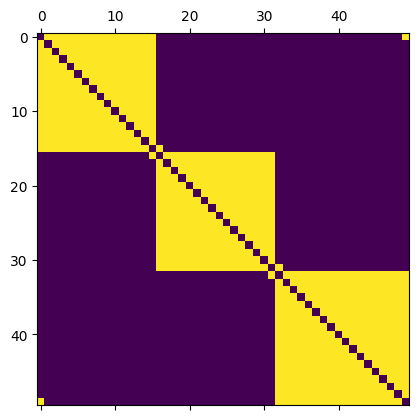

Average number of clones: 1.0


  0%|          | 2/1000 [00:00<07:57,  2.09it/s, train_bps=3.86]


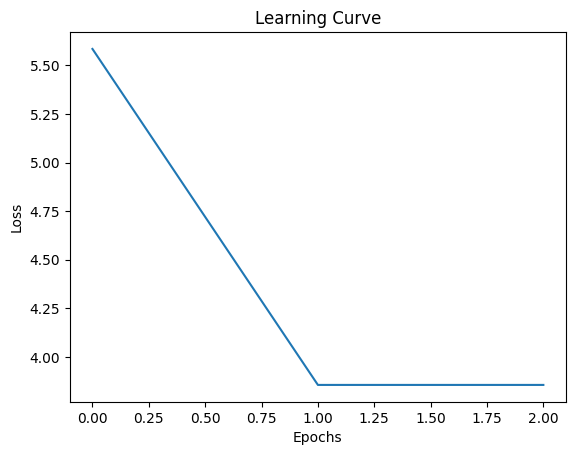

  2%|▏         | 2/100 [00:00<00:20,  4.85it/s, train_bps=3.86]


Clustering with 38 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
[1] 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31
[2] 32, 33, 34, 35, 36, 37
Modularity Score: 0.47


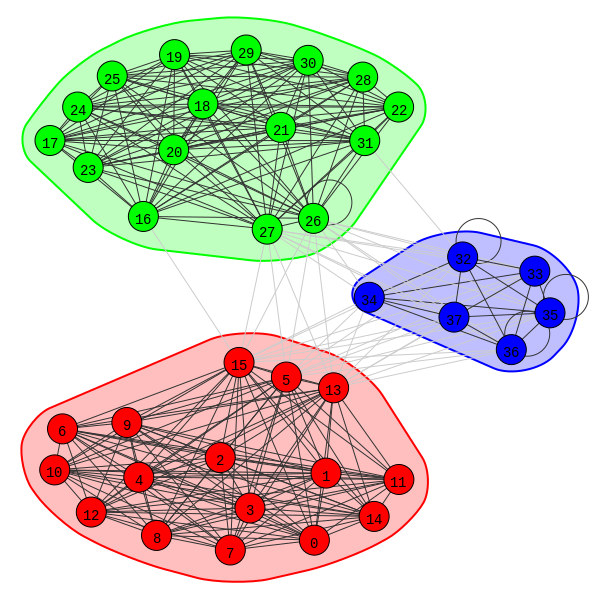

2 clones: modular graph
50 nodes, 12 aliased states, 3 modules


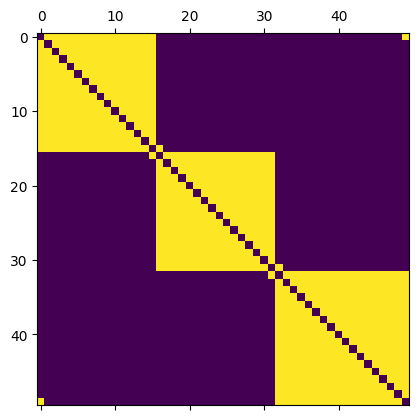

Average number of clones: 2.0


 26%|██▌       | 258/1000 [00:14<00:40, 18.21it/s, train_bps=3.75]


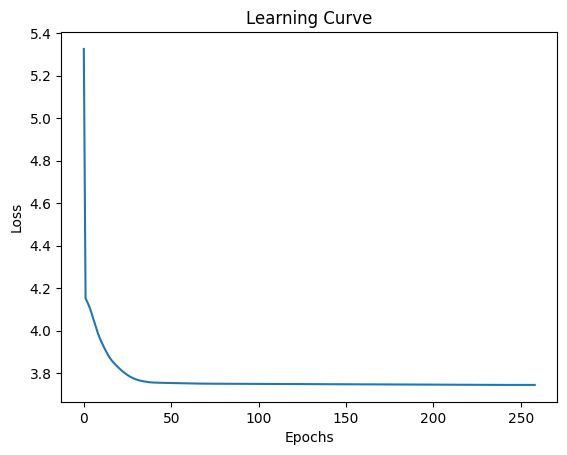

  3%|▎         | 3/100 [00:00<00:06, 14.39it/s, train_bps=3.78]


Clustering with 76 elements and 3 clusters
[0] 0, 12, 14, 22, 29, 36, 39, 47, 49, 54, 64, 65, 66, 67, 68, 69, 70, 71, 72,
    73, 74, 75
[1] 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24,
    25, 26, 27, 28, 30, 31
[2] 32, 33, 34, 35, 37, 38, 40, 41, 42, 43, 44, 45, 46, 48, 50, 51, 52, 53,
    55, 56, 57, 58, 59, 60, 61, 62, 63
Modularity Score: 0.65


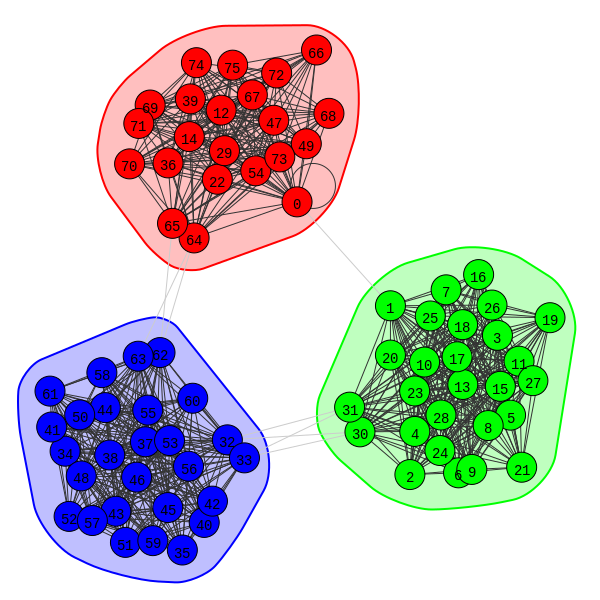

3 clones: modular graph
50 nodes, 12 aliased states, 3 modules


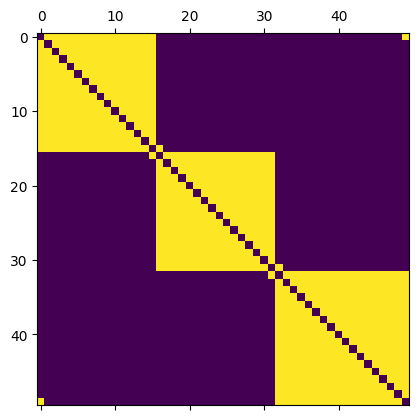

Average number of clones: 3.0


 69%|██████▉   | 688/1000 [00:37<00:16, 18.48it/s, train_bps=3.47]


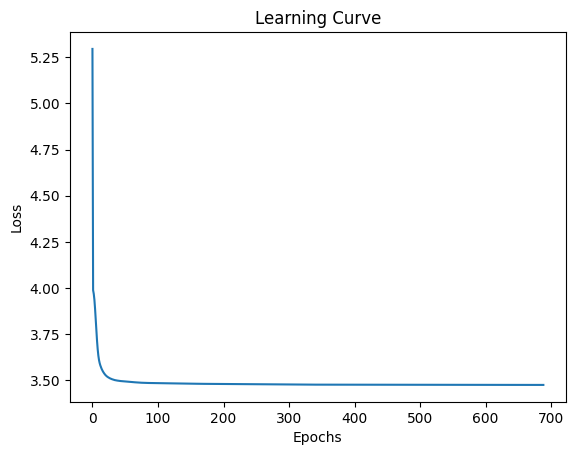

  5%|▌         | 5/100 [00:01<00:19,  4.94it/s, train_bps=3.51]

Clustering with 114 elements and 3 clusters
[0] 0, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
    23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42,
    43, 44, 45, 46, 47
[1] 1, 6, 8, 28, 33, 52, 53, 88, 89, 90, 96, 97, 98, 99, 100, 101, 102, 103,
    104, 105, 106, 107, 108, 109, 110, 111, 112, 113
[2] 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
    68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
    86, 87, 91, 92, 93, 94, 95
Modularity Score: 0.63


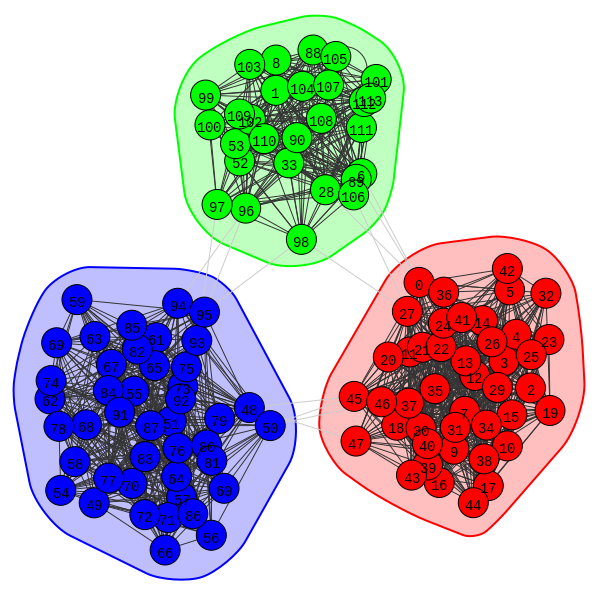

4 clones: modular graph
50 nodes, 12 aliased states, 3 modules


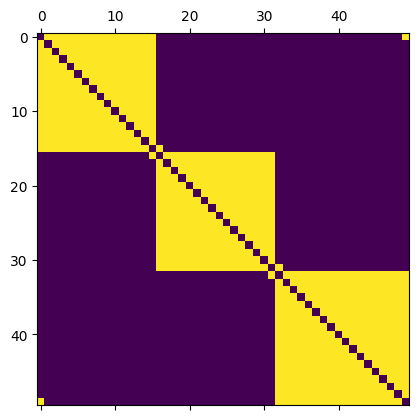

Average number of clones: 4.0


 45%|████▌     | 451/1000 [00:24<00:29, 18.60it/s, train_bps=3.36]


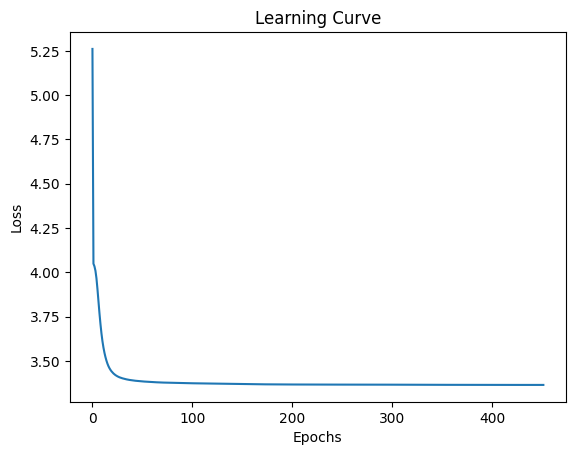

  4%|▍         | 4/100 [00:00<00:07, 12.89it/s, train_bps=3.39]


Clustering with 152 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
    22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41,
    42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 57, 59, 60, 61, 62, 63
[1] 6, 36, 37, 52, 54, 55, 56, 58, 70, 96, 97, 108, 121, 122, 128, 129, 130,
    131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
    146, 147, 148, 149, 150, 151
[2] 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
    83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 98, 99, 100, 101, 102,
    103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
    119, 120, 123, 124, 125, 126, 127
Modularity Score: 0.63


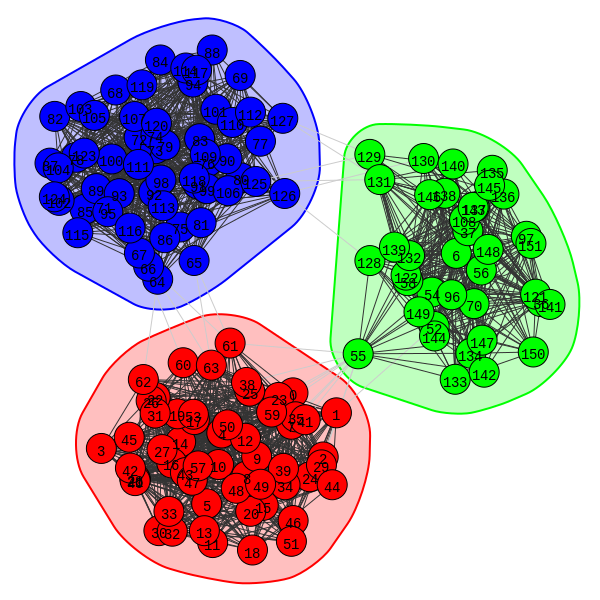

5 clones: modular graph
50 nodes, 12 aliased states, 3 modules


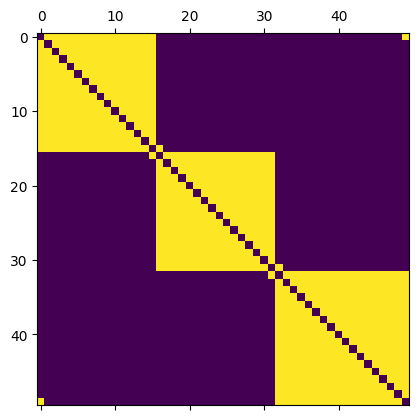

Average number of clones: 5.0


 50%|█████     | 505/1000 [00:34<00:33, 14.75it/s, train_bps=3.32]


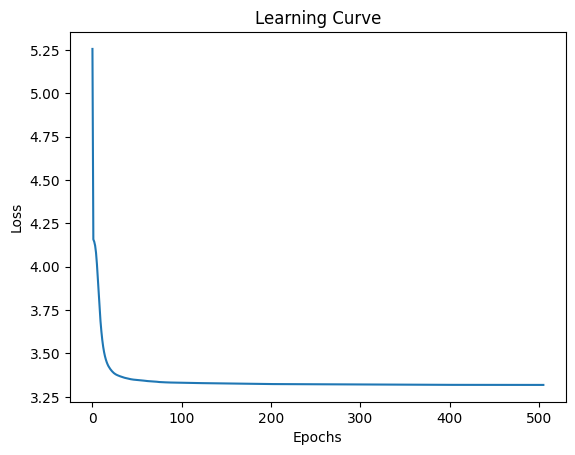

  3%|▎         | 3/100 [00:00<00:08, 11.49it/s, train_bps=3.33]


Clustering with 190 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21,
    22, 23, 24, 25, 26, 27, 30, 31, 36, 37, 40, 42, 43, 45, 46, 47, 48, 49,
    50, 51, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
    71, 72, 73, 74, 75, 76, 77, 78, 79
[1] 14, 28, 29, 32, 33, 34, 35, 38, 39, 41, 44, 52, 53, 54, 85, 87, 89, 92,
    93, 94, 137, 138, 139, 140, 142, 160, 161, 162, 163, 164, 165, 166, 167,
    168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
    183, 184, 185, 186, 187, 188, 189
[2] 80, 81, 82, 83, 84, 86, 88, 90, 91, 95, 96, 97, 98, 99, 100, 101, 102,
    103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
    118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
    133, 134, 135, 136, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
    153, 154, 155, 156, 157, 158, 159
Modularity Score: 0.64


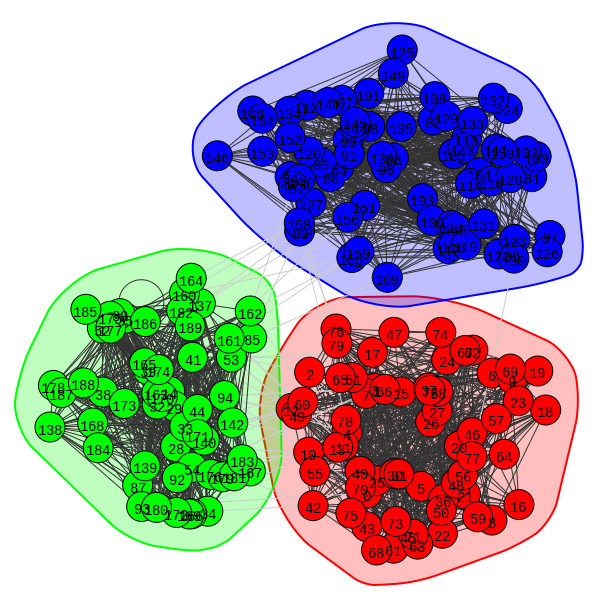

6 clones: modular graph
50 nodes, 12 aliased states, 3 modules


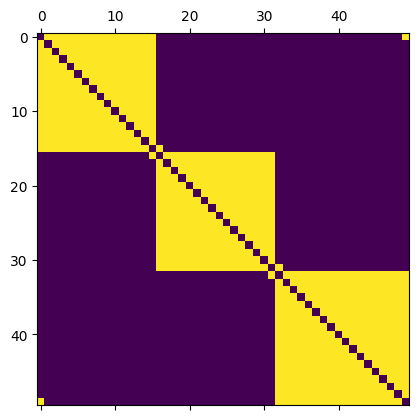

Average number of clones: 6.0


 78%|███████▊  | 779/1000 [00:56<00:15, 13.87it/s, train_bps=3.14]


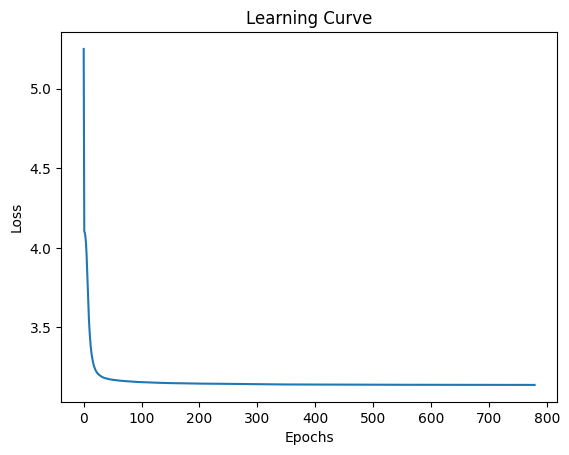

  4%|▍         | 4/100 [00:00<00:09, 10.58it/s, train_bps=3.14]


Clustering with 228 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22,
    23, 25, 28, 30, 31, 32, 33, 34, 35, 36, 39, 42, 43, 44, 45, 46, 47, 48,
    49, 50, 51, 52, 53, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
    70, 71, 72, 73, 74, 75, 76, 77, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91,
    92, 93, 94, 95
[1] 12, 14, 24, 26, 27, 29, 37, 38, 40, 41, 54, 55, 57, 78, 79, 82, 83, 114,
    115, 117, 118, 120, 121, 123, 124, 151, 153, 157, 158, 159, 192, 193, 194,
    195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
    210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
    225, 226, 227
[2] 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
    111, 112, 113, 116, 119, 122, 125, 126, 127, 128, 129, 130, 131, 132, 133,
    134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
    149, 150, 152, 154, 155, 156, 160, 161, 162, 163, 164, 165, 16

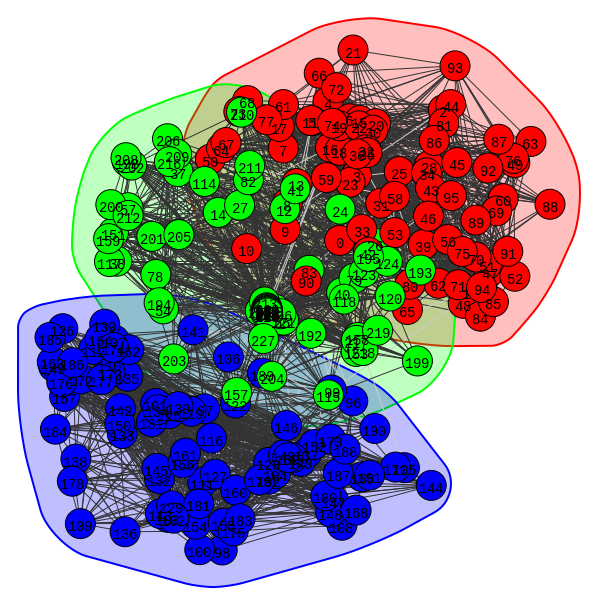

7 clones: modular graph
50 nodes, 12 aliased states, 3 modules


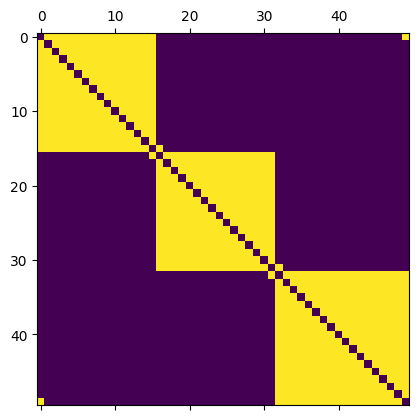

Average number of clones: 7.0


 60%|█████▉    | 598/1000 [00:41<00:27, 14.54it/s, train_bps=3.06]


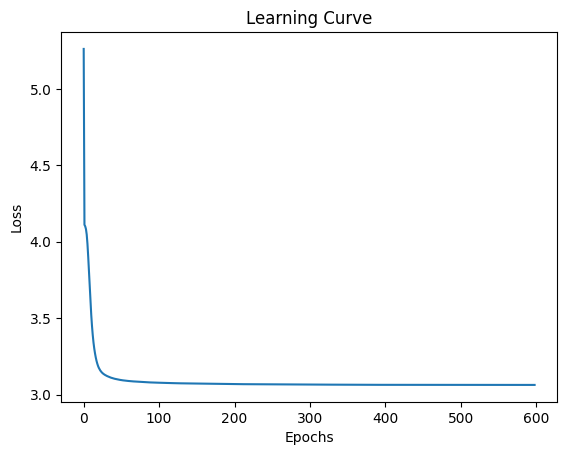

  2%|▏         | 2/100 [00:00<00:21,  4.65it/s, train_bps=3.06]


Clustering with 266 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 9, 11, 14, 15, 16, 17, 18, 19, 20, 22, 27, 28, 29,
    30, 31, 32, 33, 34, 35, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 51, 53,
    54, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
    76, 77, 78, 79, 80, 81, 82, 83, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97,
    98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111
[1] 7, 8, 10, 12, 13, 21, 23, 24, 25, 26, 36, 37, 38, 41, 50, 52, 55, 56, 57,
    62, 84, 85, 89, 90, 119, 120, 123, 124, 147, 150, 152, 153, 162, 164, 165,
    166, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
    238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
    253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265
[2] 112, 113, 114, 115, 116, 117, 118, 121, 122, 125, 126, 127, 128, 129, 130,
    131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
    146, 148, 149, 151, 154, 155, 156, 1

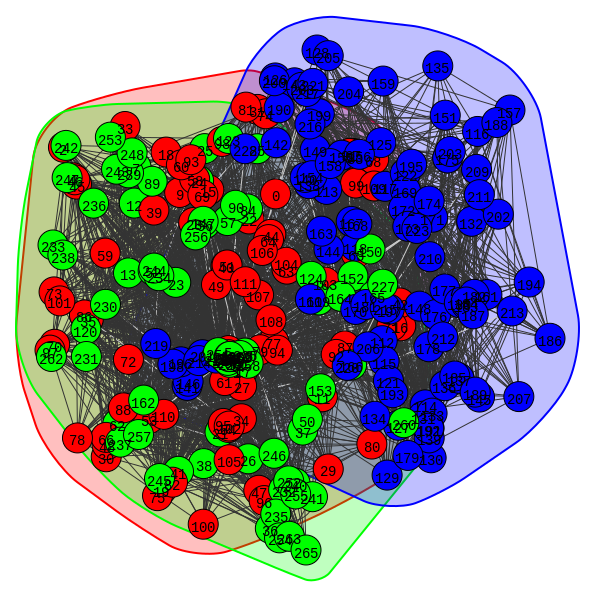

8 clones: modular graph
50 nodes, 12 aliased states, 3 modules


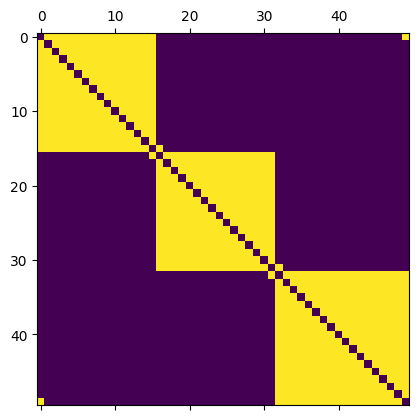

Average number of clones: 8.0


 50%|█████     | 502/1000 [00:35<00:35, 13.95it/s, train_bps=2.96]


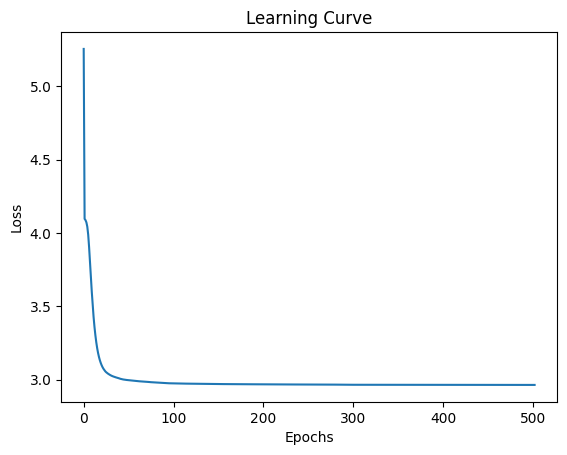

  2%|▏         | 2/100 [00:00<00:14,  6.58it/s, train_bps=2.95]


Clustering with 304 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
    39, 41, 43, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 63, 64, 65,
    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
    84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101,
    102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
    117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127
[1] 40, 42, 44, 47, 57, 59, 60, 61, 62, 129, 132, 133, 177, 178, 181, 183,
    196, 197, 199, 209, 210, 213, 215, 218, 219, 220, 221, 242, 243, 244, 247,
    252, 253, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
    268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
    283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
    298, 299, 300, 301, 302, 303
[2] 128, 13

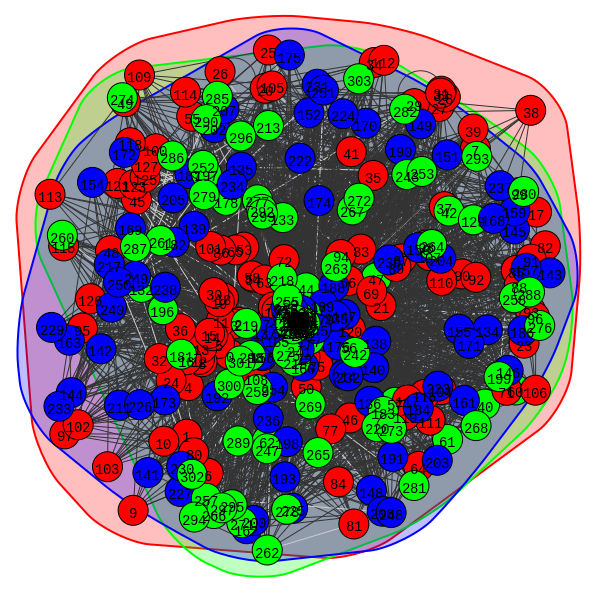

9 clones: modular graph
50 nodes, 12 aliased states, 3 modules


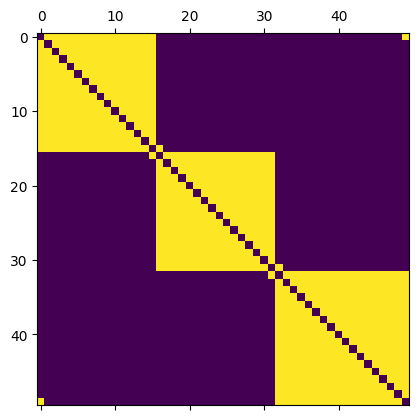

Average number of clones: 9.0


 54%|█████▍    | 540/1000 [00:48<00:41, 11.13it/s, train_bps=2.83]


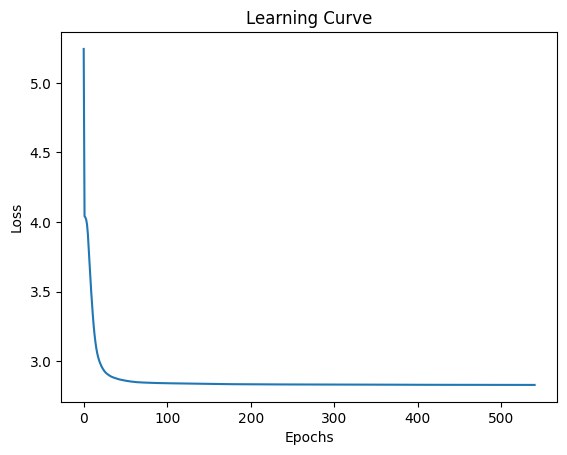

  2%|▏         | 2/100 [00:01<00:51,  1.91it/s, train_bps=2.81]


Clustering with 342 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
    39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
    57, 58, 59, 60, 61, 62, 64, 65, 69, 70, 71, 73, 78, 79, 80, 81, 82, 83,
    84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101,
    102, 103, 104, 105, 106, 107, 109, 111, 113, 117, 118, 119, 120, 121, 122,
    123, 124, 125, 126, 127, 129, 132, 135, 136, 137, 138, 139, 140, 141, 142,
    143
[1] 63, 66, 67, 68, 72, 74, 75, 76, 77, 108, 110, 112, 114, 115, 116, 128,
    130, 131, 133, 134, 181, 182, 184, 186, 188, 198, 200, 201, 203, 205, 207,
    208, 209, 211, 212, 215, 225, 226, 227, 228, 232, 233, 288, 289, 290, 291,
    292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
    307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321,
    322, 323, 3

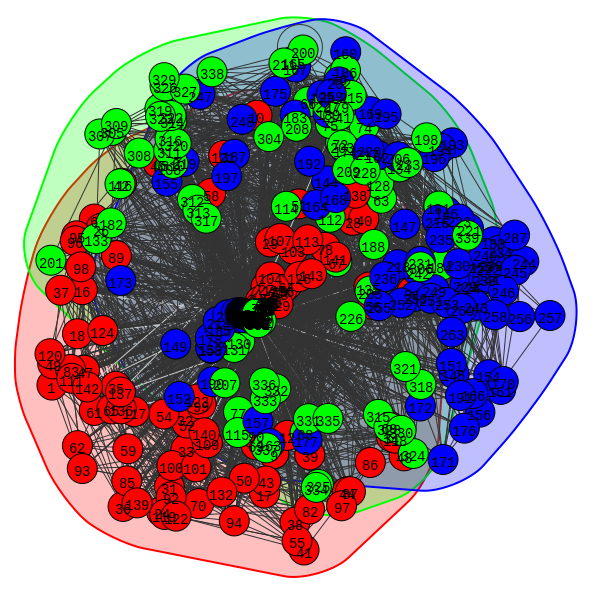

10 clones: modular graph
50 nodes, 12 aliased states, 3 modules


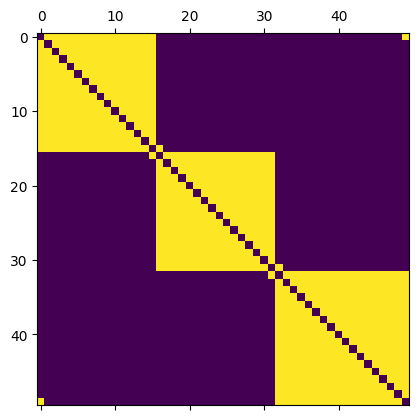

Average number of clones: 10.0


 37%|███▋      | 368/1000 [00:38<01:05,  9.67it/s, train_bps=2.75]


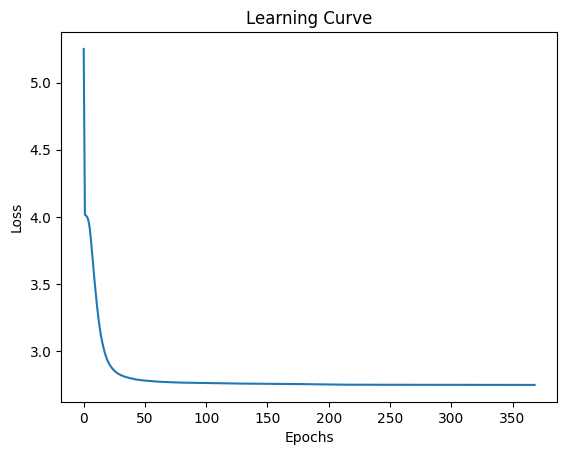

  2%|▏         | 2/100 [00:01<00:54,  1.79it/s, train_bps=2.72]


Clustering with 380 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 15, 17, 18, 20, 21, 22, 23, 24, 25,
    26, 27, 28, 29, 30, 34, 36, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
    51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 66, 68, 70, 71, 72, 73, 74, 75,
    76, 77, 78, 79, 80, 83, 84, 85, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
    100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
    115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
    130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
    145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159
[1] 10, 13, 14, 16, 19, 31, 32, 33, 35, 37, 38, 39, 60, 61, 63, 64, 65, 67,
    69, 81, 82, 86, 87, 88, 89, 160, 161, 163, 165, 167, 169, 280, 281, 286,
    287, 288, 289, 301, 302, 303, 304, 307, 320, 321, 322, 323, 324, 325, 326,
    327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341,
    342, 343, 344, 345, 

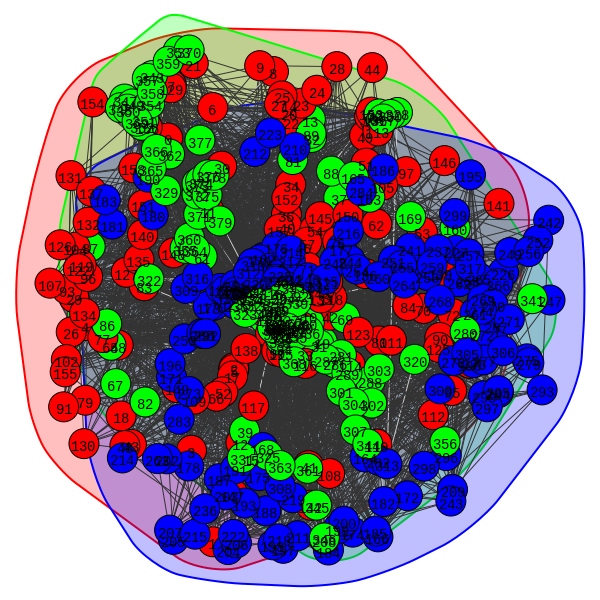

11 clones: modular graph
50 nodes, 12 aliased states, 3 modules


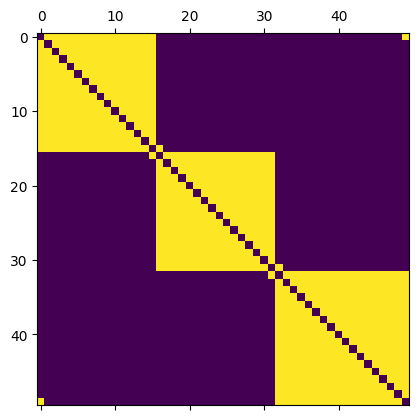

Average number of clones: 11.0


 26%|██▋       | 265/1000 [00:30<01:25,  8.60it/s, train_bps=2.72]


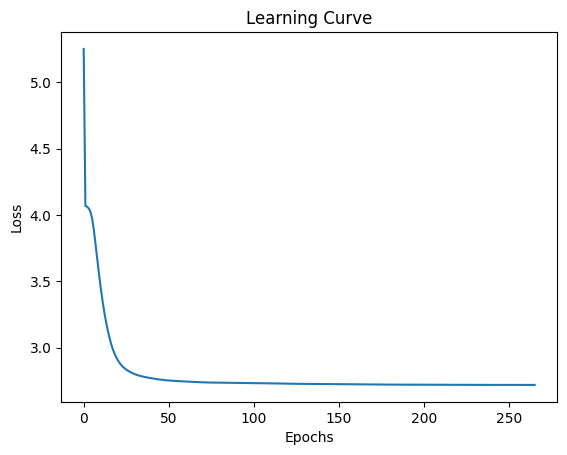

  2%|▏         | 2/100 [00:00<00:45,  2.17it/s, train_bps=2.68]


Clustering with 418 elements and 3 clusters
[0] 0, 2, 3, 4, 5, 6, 7, 10, 34, 35, 36, 37, 38, 39, 41, 42, 43, 55, 56, 59,
    61, 63, 64, 110, 112, 114, 115, 116, 117, 132, 133, 138, 139, 141, 142,
    177, 179, 181, 182, 183, 184, 185, 209, 210, 212, 213, 215, 217, 218, 219,
    298, 299, 301, 302, 303, 305, 307, 352, 353, 354, 355, 356, 357, 358, 359,
    360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374,
    375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389,
    390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
    405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417
[1] 1, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
    27, 28, 29, 30, 31, 32, 33, 40, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
    54, 57, 58, 60, 62, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
    78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
    96, 97, 98, 99, 100, 101, 102, 

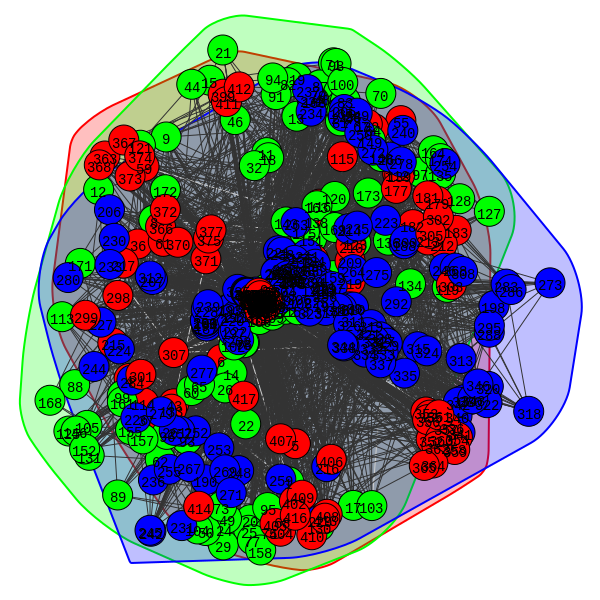

12 clones: modular graph
50 nodes, 12 aliased states, 3 modules


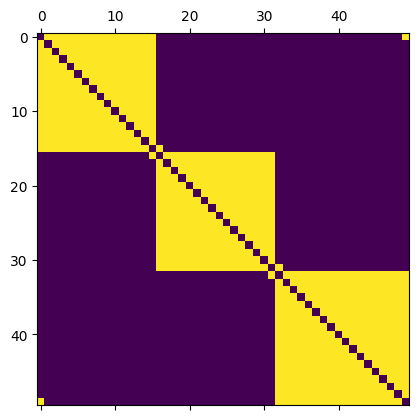

Average number of clones: 12.0


 48%|████▊     | 480/1000 [00:58<01:03,  8.23it/s, train_bps=2.56]


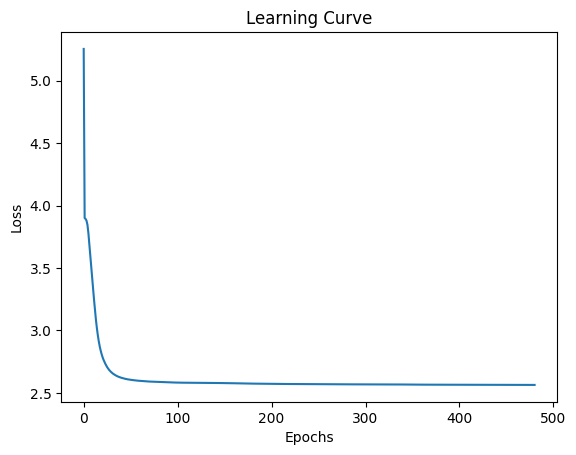

  2%|▏         | 2/100 [00:00<00:16,  6.01it/s, train_bps=2.51]


Clustering with 456 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 41, 49,
    60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
    78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
    96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
    111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
    126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
    141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
    156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 172, 174,
    178, 180, 181, 182, 183, 187, 188, 191
[1] 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56,
    57, 58, 59, 168, 170, 171, 173, 175, 176, 177, 179, 184, 185, 186, 189,
    190, 327, 329, 331, 334, 335, 372, 374, 376, 377, 378, 379, 

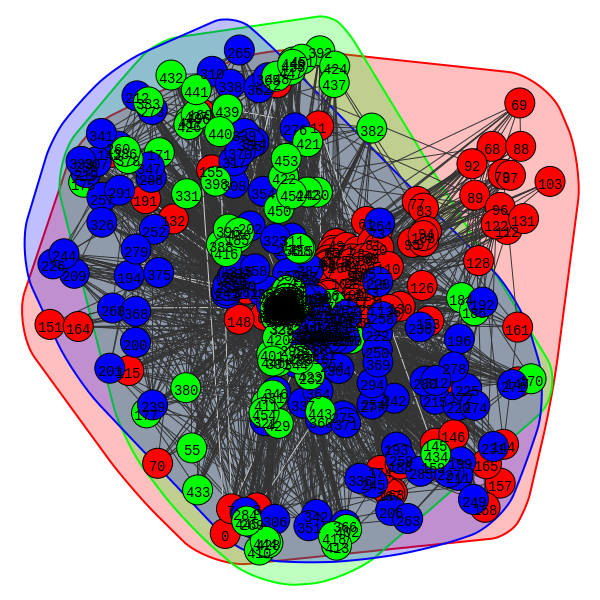

13 clones: modular graph
50 nodes, 12 aliased states, 3 modules


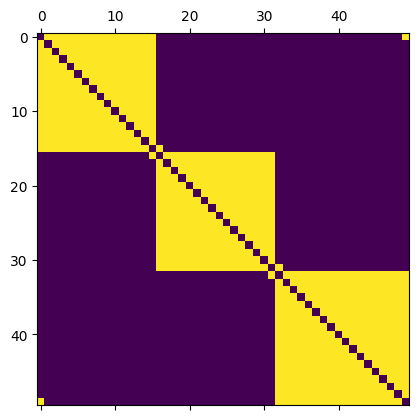

Average number of clones: 13.0


 29%|██▉       | 288/1000 [00:43<01:46,  6.67it/s, train_bps=2.56]


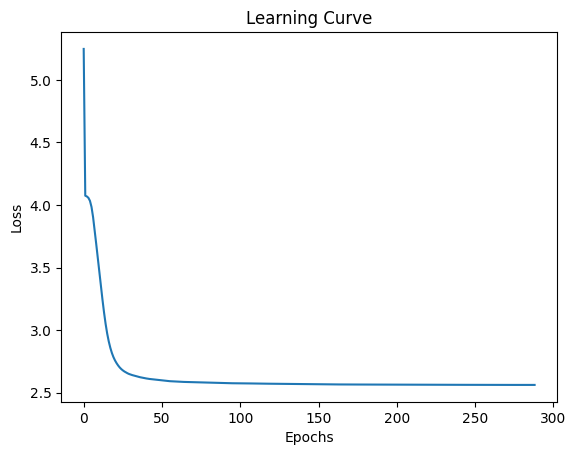

  2%|▏         | 2/100 [00:00<00:24,  4.01it/s, train_bps=2.5]


Clustering with 493 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
    39, 44, 45, 46, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
    63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 84,
    85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
    103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
    118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
    133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
    148, 149, 150, 151, 152, 153, 154, 156, 158, 161, 164, 165, 168, 169, 170,
    171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
    186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
    201, 202, 203, 204, 205, 206
[1] 40, 41, 42, 43, 47, 48, 77, 81, 82, 83, 87, 155, 157, 159, 160, 

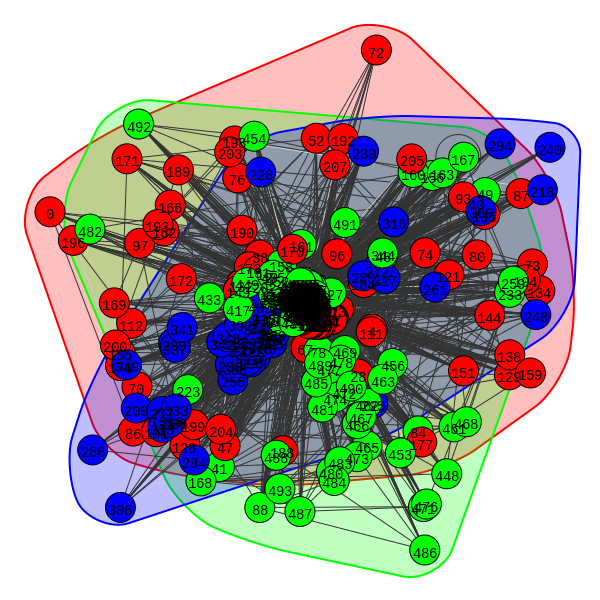

14 clones: modular graph
50 nodes, 12 aliased states, 3 modules


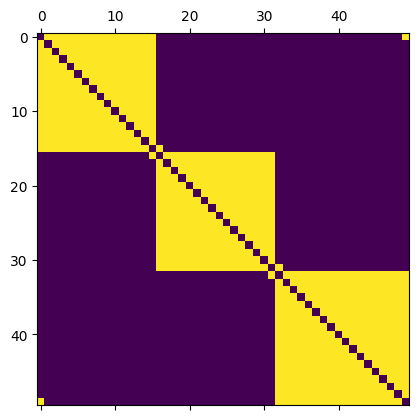

Average number of clones: 14.0


 44%|████▎     | 435/1000 [01:13<01:34,  5.95it/s, train_bps=2.49]


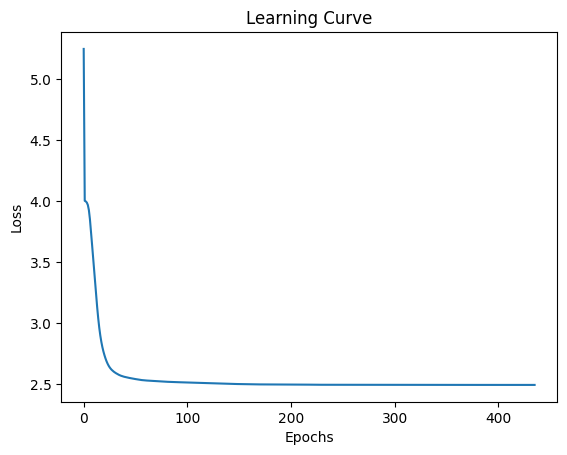

  2%|▏         | 2/100 [00:01<01:01,  1.58it/s, train_bps=2.42]


Clustering with 530 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 29, 30, 36, 37, 38, 39, 40, 42, 43, 44, 45,
    46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
    64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
    100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
    115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
    130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 144, 145, 149, 150,
    152, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
    170, 174, 175, 177, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
    193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
    208, 209, 211, 212, 215, 217, 218, 221, 222, 223
[1] 28, 31, 32, 33, 34, 35, 41, 140, 142, 143, 

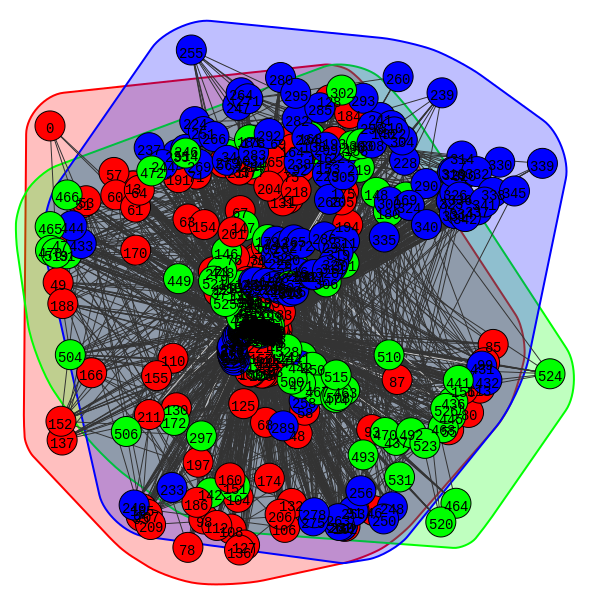

In [ ]:
# var_nodes = np.arange(5,50,5)
from IPython.display import display, Image
import igraph

num_nodes = 50
num_observations = 10000
num_aliased_states = 2  # Adjust this to change the number of aliased states
num_clones = 10
num_modules=3
var_clones = np.arange(1,15,1)
total_modularity_scores = []
# var_aliasing = np.arange(2,4,1)
var_aliasing=[4]
for num_clones in var_clones:
  modularity_scores = []
  for aliasing in var_aliasing:

    num_aliased_states = num_nodes//aliasing  # Adjust this to change the number of aliased states

    #1. MODULAR GRAPH
    print("{} clones: modular graph".format(num_clones))
    print("{} nodes, {} aliased states, {} modules".format(num_nodes, num_aliased_states,num_modules))

    # Create observation data
    x = create_modular_graph_varied(num_nodes, num_observations, num_aliased_states, num_modules)
    a = np.zeros(len(x), dtype=int)

    n_clones = np.ones(max(x)+1, dtype=np.int64) * num_clones
    # container = TableContainer()
    chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training

    # refine learning
    chmm.pseudocount = 0.0
    chmm.learn_viterbi_T(x, a, n_iter=100)
    states = chmm.decode(x, a)[1]
    n_states = len(np.unique(states))

    custom_colors = generate_custom_colors(max(x)+1)/256
    arr = np.arange(max(x)+1)
    np.random.shuffle(arr)
    cmap = colors.ListedColormap(custom_colors[arr])

    temp_output_file = f"modular_graph_num_nodes_{num_nodes}.png"  # Temporary file for each clone
    graph, modularity_score = plot_graph_modularity(chmm, x, a, output_file=temp_output_file, cmap=cmap)
    # print('Ground truth number of nodes: {}, number of nodes recovered {}'.format(num_nodes, len(v)))
    # Display the image inline
    display(Image(filename=temp_output_file))

    modularity_scores.append(modularity_score)
  total_modularity_scores.append(modularity_scores)


  # #2. LATTICE GRAPH
  # print("{} clones: lattice graph".format(num_clones))
  # print("{} nodes, {} aliased states".format(num_nodes, num_aliased_states))

  # # Create observation data
  # x = create_lattice_graph_varied(num_nodes, num_observations, num_aliased_states)
  # a = np.zeros(len(x), dtype=int)

  # n_clones = np.ones(max(x)+1, dtype=np.int64) * num_clones
  # chmm = CHMM(n_clones=n_clones, pseudocount=1.0, x=x, a=a)  # Initialize the model
  # progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training

  # # refine learning
  # chmm.pseudocount = 0.0
  # chmm.learn_viterbi_T(x, a, n_iter=100)
  # states = chmm.decode(x, a)[1]
  # n_states = len(np.unique(states))
  # n_states

  # custom_colors = generate_custom_colors(max(x)+1)/256
  # arr = np.arange(max(x)+1)
  # np.random.shuffle(arr)

  # cmap = colors.ListedColormap(custom_colors[arr])

  # temp_output_file = f"lattice_graph_num_clones_{num_clones}.png"  # Temporary file for each clone
  # graph, v = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)
  # print('Ground truth number of nodes: {}, number of nodes recovered {}'.format(num_nodes, len(v)))
  # # Display the image inline
  # display(Image(filename=temp_output_file))



In [ ]:
total_modularity_scores


In [ ]:
clones = np.arange(1,20)

T = np.zeros((15, 15))
# Connect cliques
for i in range(0, 4 + 1):
    for j in range(0, 4 + 1):
        if i != j:
            T[i, j] = 1.0
for i in range(5, 9 + 1):
    for j in range(5, 9 + 1):
        if i != j:
            T[i, j] = 1.0
for i in range(10, 14 + 1):
    for j in range(10, 14 + 1):
        if i != j:
            T[i, j] = 1.0
# Disconnect in clique connector nodes
T[0, 4] = 0.0
T[4, 0] = 0.0
T[5, 9] = 0.0
T[9, 5] = 0.0
T[10, 14] = 0.0
T[14, 10] = 0.0
# Connect cross clique connector nodes
T[4, 5] = 1.0
T[5, 4] = 1.0
T[9, 10] = 1.0
T[10, 9] = 1.0
T[14, 0] = 1.0
T[0, 14] = 1.0
plt.matshow(T)
plt.show()


# Draw data
states = [0]
for _ in range(10000):
    prev_state = states[-1]

    possible_next_states = np.where(T[prev_state, :])[0]
    next_state = np.random.choice(possible_next_states)
    states.append(next_state)
states = np.array(states)

state_to_obs = (
    np.array([1, 2, 3, 4, 5, 6, 1, 4, 5, 2, 8, 2, 3, 5, 7], dtype=int) - 1
)  # Aliasing version

# Create observation data
x = state_to_obs[states]
a = np.zeros(len(x), dtype=int)


for clone in clones:


  n_clones = np.ones(8, dtype=np.int64) * clone
  chmm = CHMM(n_clones=n_clones, pseudocount=1.0, x=x, a=a)  # Initialize the model
  progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training


  # refine learning
  chmm.pseudocount = 0.0
  chmm.learn_viterbi_T(x, a, n_iter=100)
  loglik, states, ginis = chmm.decode(x, a)
  plt.hist(ginis)
  plt.show()
  n_states = len(np.unique(states))
  n_states

  cmap = colors.ListedColormap(custom_colors[[7, 3, 2, 1, 5, 0, 4, 6]])
  # graph = plot_graph(chmm, x, a, output_file="figures/pentagonal_cliques.pdf", cmap=cmap)


  temp_output_file = f"temp_figure_{clone}.png"  # Temporary file for each clone
  # graph = plot_graph_infomap(chmm, x, a, output_file=temp_output_file, cmap=cmap)
  graph = plot_graph_modularity(chmm, x, a, output_file=temp_output_file, cmap=cmap)

  # Display the image inline
  display(Image(filename=temp_output_file))





  # print(graph)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_clique_matrix(num_cliques, clique_size=5, visualize=False):
    # Calculate the total size of the matrix
    total_size = num_cliques * clique_size
    T = np.zeros((total_size, total_size))

    # Connect nodes within each clique
    for n in range(num_cliques):
        start_index = n * clique_size
        end_index = start_index + clique_size
        for i in range(start_index, end_index):
            for j in range(start_index, end_index):
                if i != j:
                    T[i, j] = 1.0

    # Disconnect in-clique connector nodes and connect cross-clique connector nodes
    for n in range(num_cliques - 1):
        # Disconnect in-clique connector nodes
        T[n*clique_size, (n+1)*clique_size-1] = 0.0
        T[(n+1)*clique_size-1, n*clique_size] = 0.0

        # Connect cross-clique connector nodes
        T[(n+1)*clique_size-1, (n+1)*clique_size] = 1.0
        T[(n+1)*clique_size, (n+1)*clique_size-1] = 1.0

    # Special case for connecting the last clique with the first
    T[0, total_size - 1] = 1.0
    T[total_size - 1, 0] = 1.0

    # Visualize the matrix
    if visualize:
      plt.matshow(T)
      plt.show()

    return T

def visualize_graph(T):
    G = nx.from_numpy_array(T)  # Use from_numpy_array here
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.title("Graph Structure")
    plt.show()

# Example usage
T = create_clique_matrix(8)
visualize_graph(T)


In [ ]:
for n_clique in (3,10,1):
  T = create_clique_matrix(n_clique)

In [ ]:
n = 10
table_counts = [[{1:1, 2:3}],[{1:2, 3:5}]]

In [ ]:
table_counts[0]


In [ ]:
curr_observation = 1

In [ ]:
assignment, table_counts = CRP(n, table_counts, curr_observation)

In [ ]:
n_emissions = 4
n_clones = 20 * np.ones(n_emissions, int)

In [ ]:
all_table_counts = {}
for i in range(1, len(n_clones) + 1):
    all_table_counts[i] = {1: 1}  # Each table initialized with {1: 1}
all_table_counts

In [ ]:
container = TableContainer()
observations = [1,2,1,1,1,1,3,3,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1]
for obs in observations:
  assignments, probs = CRP(container, obs, alpha=0.4)
  print("Observation {}: assignments = {}, probs = {}".format(obs, assignments, probs))

In [ ]:
container.count_tables_in_group(1)

In [ ]:
container.get_

In [ ]:
container.get_table_total(2,3)

In [ ]:
len(observations
    )

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def chinese_restaurant_process(customers, alpha=1.0):
#     """
#     Simulates the Chinese Restaurant Process.

#     Parameters:
#     - customers: int, the total number of customers to simulate.
#     - alpha: float, the concentration parameter.

#     Returns:
#     - A list where the i-th element represents the table number of the i-th customer.
#     """
#     if customers <= 0:
#         return []

#     # The table assignments for each customer
#     assignments = [1]  # The first customer always chooses the first table
#     table_counts = {1: 1}  # Table 1 has one customer

#     for n in range(1, customers):  # Start with the second customer
#         # Compute the probabilities for each table and a new table
#         probs = [count / (n + alpha) for count in table_counts.values()] + [alpha / (n + alpha)]
#         print(probs)
#         # Choose a table based on the probabilities
#         table_choice = np.random.choice(len(probs), p=probs)

#         if table_choice == len(table_counts):
#             # Create a new table
#             table_counts[table_choice + 1] = 1
#             assignments.append(table_choice + 1)
#         else:
#             # Join an existing table
#             table = list(table_counts.keys())[table_choice]
#             table_counts[table] += 1
#             assignments.append(table)

#     return assignments

# # Example usage
# customers = 10  # Number of customers
# alpha = 1.0  # Concentration parameter
# assignments = chinese_restaurant_process(customers, alpha)
# print("Table assignments:", assignments)
# print("Number of tables: ", np.unique(assignments))
# plt.hist(assignments)
# plt.show()






In [ ]:
n=2

[alpha / (n + alpha)]

In [ ]:
for alpha in np.arange(0,1,0.1):
  customers = 100  # Number of customers
  assignments = chinese_restaurant_process(customers, alpha)
  print("alpha: ", alpha)
  # print("Table assignments in alpha={}: {}".format(alpha, assignments))
  print("Number of tables: ", np.unique(assignments))
  plt.hist(assignments)
  plt.show()

In [ ]:
np.arange(0,1,0.1
          )

In [ ]:
# from __future__ import print_function
# from builtins import range
# import numpy as np
# import numba as nb
# from tqdm import trange
# import sys
# import networkx as nx  # Import the networkx library
# from numba import jit

# def validate_seq(x, a, n_clones=None):
#     """Validate an input sequence of observations x and actions a"""
#     assert len(x) == len(a) > 0
#     assert len(x.shape) == len(a.shape) == 1, "Flatten your array first"
#     assert x.dtype == a.dtype == np.int64
#     assert 0 <= x.min(), "Number of emissions inconsistent with training sequence"
#     if n_clones is not None:
#         assert len(n_clones.shape) == 1, "Flatten your array first"
#         assert n_clones.dtype == np.int64
#         assert all(
#             [c > 0 for c in n_clones]
#         ), "You can't provide zero clones for any emission"
#         n_emissions = n_clones.shape[0]
#         assert (
#             x.max() < n_emissions
#         ), "Number of emissions inconsistent with training sequence"


# def datagen_structured_obs_room(
#     room,
#     start_r=None,
#     start_c=None,
#     no_left=[],
#     no_right=[],
#     no_up=[],
#     no_down=[],
#     length=10000,
#     seed=42,
# ):
#     """room is a 2d numpy array. inaccessible locations are marked by -1.
#     start_r, start_c: starting locations

#     In addition, there are invisible obstructions in the room
#     which disallows certain actions from certain states.

#     no_left:
#     no_right:
#     no_up:
#     no_down:

#     Each of the above are list of states from which the corresponding action is not allowed.

#     """
#     np.random.seed(seed)
#     H, W = room.shape
#     if start_r is None or start_c is None:
#         start_r, start_c = np.random.randint(H), np.random.randint(W)

#     actions = np.zeros(length, int)
#     x = np.zeros(length, int)  # observations
#     rc = np.zeros((length, 2), int)  # actual r&c

#     r, c = start_r, start_c
#     x[0] = room[r, c]
#     rc[0] = r, c

#     count = 0
#     while count < length - 1:

#         act_list = [0, 1, 2, 3]  # 0: left, 1: right, 2: up, 3: down
#         if (r, c) in no_left:
#             act_list.remove(0)
#         if (r, c) in no_right:
#             act_list.remove(1)
#         if (r, c) in no_up:
#             act_list.remove(2)
#         if (r, c) in no_down:
#             act_list.remove(3)

#         a = np.random.choice(act_list)

#         # Check for actions taking out of the matrix boundary.
#         prev_r = r
#         prev_c = c
#         if a == 0 and 0 < c:
#             c -= 1
#         elif a == 1 and c < W - 1:
#             c += 1
#         elif a == 2 and 0 < r:
#             r -= 1
#         elif a == 3 and r < H - 1:
#             r += 1

#         # Check whether action is taking to inaccessible states.
#         temp_x = room[r, c]
#         if temp_x == -1:
#             r = prev_r
#             c = prev_c
#             pass

#         actions[count] = a
#         x[count + 1] = room[r, c]
#         rc[count + 1] = r, c
#         count += 1

#     return actions, x, rc


# class CHMM(object):
#     def __init__(self, n_clones, x, a, pseudocount=0.0, dtype=np.float32, seed=42):
#         """Construct a CHMM objct. n_clones is an array where n_clones[i] is the
#         number of clones assigned to observation i. x and a are the observation sequences
#         and action sequences, respectively."""
#         np.random.seed(seed)
#         self.n_clones = n_clones
#         validate_seq(x, a, self.n_clones)
#         assert pseudocount >= 0.0, "The pseudocount should be positive"
#         print("Average number of clones:", n_clones.mean())
#         self.pseudocount = pseudocount
#         self.dtype = dtype
#         n_states = self.n_clones.sum()
#         n_actions = a.max() + 1
#         self.C = np.random.rand(n_actions, n_states, n_states).astype(dtype)
#         self.Pi_x = np.ones(n_states) / n_states
#         self.Pi_a = np.ones(n_actions) / n_actions
#         self.update_T()

#     def update_T(self):
#         """Update the transition matrix given the accumulated counts matrix."""
#         self.T = self.C + self.pseudocount
#         norm = self.T.sum(2, keepdims=True)
#         norm[norm == 0] = 1
#         self.T /= norm

#     # def update_T(self):
#     #     self.T = self.C + self.pseudocount
#     #     norm = self.T.sum(2, keepdims=True)  # old model (conditional on actions)
#     #     norm[norm == 0] = 1
#     #     self.T /= norm
#     #     norm = self.T.sum((0, 2), keepdims=True)  # new model (generates actions too)
#     #     norm[norm == 0] = 1
#     #     self.T /= norm

#     def update_E(self, CE):
#         """Update the emission matrix."""
#         E = CE + self.pseudocount
#         norm = E.sum(1, keepdims=True)
#         norm[norm == 0] = 1
#         E /= norm
#         return E

#     def bps(self, x, a):
#         """Compute the log likelihood (log base 2) of a sequence of observations and actions."""
#         validate_seq(x, a, self.n_clones)
#         log2_lik = forward(self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a)[0]
#         return -log2_lik

#     def bpsE(self, E, x, a):
#         """Compute the log likelihood using an alternate emission matrix."""
#         validate_seq(x, a, self.n_clones)
#         log2_lik = forwardE(
#             self.T.transpose(0, 2, 1), E, self.Pi_x, self.n_clones, x, a
#         )
#         return -log2_lik

#     def bpsV(self, x, a):
#         validate_seq(x, a, self.n_clones)
#         log2_lik = forward_mp(
#             self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a
#         )[0]
#         return -log2_lik

#     def decode(self, x, a):
#         """Compute the MAP assignment of latent variables using max-product message passing."""
#         log2_lik, mess_fwd = forward_mp(
#             self.T.transpose(0, 2, 1),
#             self.Pi_x,
#             self.n_clones,
#             x,
#             a,
#             store_messages=True,
#         )
#         states, ginis = backtrace(self.T, self.n_clones, x, a, mess_fwd)
#         # print(mess_fwd)
#         return -log2_lik, states, ginis

#     def decodeE(self, E, x, a):
#         """Compute the MAP assignment of latent variables using max-product message passing
#         with an alternative emission matrix."""
#         log2_lik, mess_fwd = forwardE_mp(
#             self.T.transpose(0, 2, 1),
#             E,
#             self.Pi_x,
#             self.n_clones,
#             x,
#             a,
#             store_messages=True,
#         )
#         states = backtraceE(self.T, E, self.n_clones, x, a, mess_fwd)
#         return -log2_lik, states

#     def learn_em_T(self, x, a, n_iter=100, term_early=True):
#         """Run EM training, keeping E deterministic and fixed, learning T"""
#         sys.stdout.flush()
#         convergence = []
#         pbar = trange(n_iter, position=0)
#         log2_lik_old = -np.inf
#         for it in pbar:
#             # E
#             log2_lik, mess_fwd = forward(
#                 self.T.transpose(0, 2, 1),
#                 self.Pi_x,
#                 self.n_clones,
#                 x,
#                 a,
#                 store_messages=True,
#             )
#             mess_bwd = backward(self.T, self.n_clones, x, a)
#             updateC(self.C, self.T, self.n_clones, mess_fwd, mess_bwd, x, a)
#             # M
#             self.update_T()
#             convergence.append(-log2_lik.mean())
#             pbar.set_postfix(train_bps=convergence[-1])
#             if log2_lik.mean() <= log2_lik_old:
#                 if term_early:
#                     break
#             log2_lik_old = log2_lik.mean()
#             # print(log2_lik_old)
#         # JY added for plotting learning curve
#         plt.plot(convergence, label='Training Loss')
#         plt.title('Learning Curve')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.show()
#         return convergence

#     def learn_viterbi_T(self, x, a, n_iter=100):
#         """Run Viterbi training, keeping E deterministic and fixed, learning T"""
#         sys.stdout.flush()
#         convergence = []
#         pbar = trange(n_iter, position=0)
#         log2_lik_old = -np.inf
#         for it in pbar:
#             # E
#             log2_lik, mess_fwd = forward_mp(
#                 self.T.transpose(0, 2, 1),
#                 self.Pi_x,
#                 self.n_clones,
#                 x,
#                 a,
#                 store_messages=True,
#             )
#             states,_ = backtrace(self.T, self.n_clones, x, a, mess_fwd)
#             self.C[:] = 0
#             for t in range(1, len(x)):
#                 aij, i, j = (
#                     a[t - 1],
#                     states[t - 1],
#                     states[t],
#                 )  # at time t-1 -> t we go from observation i to observation j
#                 self.C[aij, i, j] += 1.0
#             # M
#             self.update_T()

#             convergence.append(-log2_lik.mean())
#             pbar.set_postfix(train_bps=convergence[-1])
#             if log2_lik.mean() <= log2_lik_old:
#                 break
#             log2_lik_old = log2_lik.mean()
#         return convergence

#     def learn_em_E(self, x, a, n_iter=100, pseudocount_extra=1e-20):
#         """Run Viterbi training, keeping T fixed, learning E"""
#         sys.stdout.flush()
#         n_emissions, n_states = len(self.n_clones), self.n_clones.sum()
#         CE = np.ones((n_states, n_emissions), self.dtype)
#         E = self.update_E(CE + pseudocount_extra)
#         convergence = []
#         pbar = trange(n_iter, position=0)
#         log2_lik_old = -np.inf
#         for it in pbar:
#             # E
#             log2_lik, mess_fwd = forwardE(
#                 self.T.transpose(0, 2, 1),
#                 E,
#                 self.Pi_x,
#                 self.n_clones,
#                 x,
#                 a,
#                 store_messages=True,
#             )
#             mess_bwd = backwardE(self.T, E, self.n_clones, x, a)
#             updateCE(CE, E, self.n_clones, mess_fwd, mess_bwd, x, a)
#             # M
#             E = self.update_E(CE + pseudocount_extra)
#             convergence.append(-log2_lik.mean())
#             pbar.set_postfix(train_bps=convergence[-1])
#             if log2_lik.mean() <= log2_lik_old:
#                 break
#             log2_lik_old = log2_lik.mean()
#         return convergence, E

#     def sample(self, length):
#         """Sample from the CHMM."""
#         assert length > 0
#         state_loc = np.hstack(([0], self.n_clones)).cumsum(0)
#         sample_x = np.zeros(length, dtype=np.int64)
#         sample_a = np.random.choice(len(self.Pi_a), size=length, p=self.Pi_a)

#         # Sample
#         p_h = self.Pi_x
#         for t in range(length):
#             h = np.random.choice(len(p_h), p=p_h)
#             sample_x[t] = np.digitize(h, state_loc) - 1
#             p_h = self.T[sample_a[t], h]
#         return sample_x, sample_a

#     def sample_sym(self, sym, length):
#         """Sample from the CHMM conditioning on an inital observation."""
#         # Prepare structures
#         assert length > 0
#         state_loc = np.hstack(([0], self.n_clones)).cumsum(0)

#         seq = [sym]

#         alpha = np.ones(self.n_clones[sym])
#         alpha /= alpha.sum()

#         for _ in range(length):
#             obs_tm1 = seq[-1]
#             T_weighted = self.T.sum(0)

#             long_alpha = np.dot(
#                 alpha, T_weighted[state_loc[obs_tm1] : state_loc[obs_tm1 + 1], :]
#             )
#             long_alpha /= long_alpha.sum()
#             idx = np.random.choice(np.arange(self.n_clones.sum()), p=long_alpha)

#             sym = np.digitize(idx, state_loc) - 1
#             seq.append(sym)

#             temp_alpha = long_alpha[state_loc[sym] : state_loc[sym + 1]]
#             temp_alpha /= temp_alpha.sum()
#             alpha = temp_alpha

#         return seq

#     def bridge(self, state1, state2, max_steps=100):
#         Pi_x = np.zeros(self.n_clones.sum(), dtype=self.dtype)
#         Pi_x[state1] = 1
#         log2_lik, mess_fwd = forward_mp_all(
#             self.T.transpose(0, 2, 1), Pi_x, self.Pi_a, self.n_clones, state2, max_steps
#         )
#         s_a = backtrace_all(self.T, self.Pi_a, self.n_clones, mess_fwd, state2)
#         return s_a


# def updateCE(CE, E, n_clones, mess_fwd, mess_bwd, x, a):
#     timesteps = len(x)
#     gamma = mess_fwd * mess_bwd
#     norm = gamma.sum(1, keepdims=True)
#     norm[norm == 0] = 1
#     gamma /= norm
#     CE[:] = 0
#     for t in range(timesteps):
#         CE[:, x[t]] += gamma[t]


# def forwardE(T_tr, E, Pi, n_clones, x, a, store_messages=False):
#     """Log-probability of a sequence, and optionally, messages"""
#     assert (n_clones.sum(), len(n_clones)) == E.shape
#     dtype = T_tr.dtype.type

#     # forward pass
#     t, log2_lik = 0, np.zeros(len(x), dtype)
#     j = x[t]
#     message = Pi * E[:, j]
#     p_obs = message.sum()
#     assert p_obs > 0
#     message /= p_obs
#     log2_lik[0] = np.log2(p_obs)
#     if store_messages:
#         mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
#         mess_fwd[t] = message
#     for t in range(1, x.shape[0]):
#         aij, j = (
#             a[t - 1],
#             x[t],
#         )  # at time t-1 -> t we go from observation i to observation j
#         message = T_tr[aij].dot(message)
#         message *= E[:, j]
#         p_obs = message.sum()
#         assert p_obs > 0
#         message /= p_obs
#         log2_lik[t] = np.log2(p_obs)
#         if store_messages:
#             mess_fwd[t] = message
#     if store_messages:
#         return log2_lik, mess_fwd
#     else:
#         return log2_lik


# def backwardE(T, E, n_clones, x, a):
#     """Compute backward messages."""
#     assert (n_clones.sum(), len(n_clones)) == E.shape
#     dtype = T.dtype.type

#     # backward pass
#     t = x.shape[0] - 1
#     message = np.ones(E.shape[0], dtype)
#     message /= message.sum()
#     mess_bwd = np.empty((len(x), E.shape[0]), dtype=dtype)
#     mess_bwd[t] = message
#     for t in range(x.shape[0] - 2, -1, -1):
#         aij, j = (
#             a[t],
#             x[t + 1],
#         )  # at time t -> t+1 we go from observation i to observation j
#         message = T[aij].dot(message * E[:, j])
#         p_obs = message.sum()
#         assert p_obs > 0
#         message /= p_obs
#         mess_bwd[t] = message
#     return mess_bwd


# @nb.njit
# def updateC(C, T, n_clones, mess_fwd, mess_bwd, x, a):
#     state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
#     mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
#     timesteps = len(x)
#     C[:] = 0
#     for t in range(1, timesteps):
#         aij, i, j = (
#             a[t - 1],
#             x[t - 1],
#             x[t],
#         )  # at time t-1 -> t we go from observation i to observation j
#         (tm1_start, tm1_stop), (t_start, t_stop) = (
#             mess_loc[t - 1 : t + 1],
#             mess_loc[t : t + 2],
#         )
#         (i_start, i_stop), (j_start, j_stop) = (
#             state_loc[i : i + 2],
#             state_loc[j : j + 2],
#         )
#         q = (
#             mess_fwd[tm1_start:tm1_stop].reshape(-1, 1)
#             * T[aij, i_start:i_stop, j_start:j_stop]
#             * mess_bwd[t_start:t_stop].reshape(1, -1)
#         )
#         q /= q.sum()
#         C[aij, i_start:i_stop, j_start:j_stop] += q


# @nb.njit
# def forward(T_tr, Pi, n_clones, x, a, store_messages=False):
#     """Log-probability of a sequence, and optionally, messages"""
#     state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
#     dtype = T_tr.dtype.type

#     # forward pass
#     t, log2_lik = 0, np.zeros(len(x), dtype)
#     j = x[t]
#     j_start, j_stop = state_loc[j : j + 2]
#     message = Pi[j_start:j_stop].copy().astype(dtype)
#     p_obs = message.sum()
#     assert p_obs > 0
#     message /= p_obs
#     log2_lik[0] = np.log2(p_obs)
#     if store_messages:
#         mess_loc = np.hstack(
#             (np.array([0], dtype=n_clones.dtype), n_clones[x])
#         ).cumsum()
#         mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
#         t_start, t_stop = mess_loc[t : t + 2]
#         mess_fwd[t_start:t_stop] = message
#     else:
#         mess_fwd = None

#     for t in range(1, x.shape[0]):
#         aij, i, j = (
#             a[t - 1],
#             x[t - 1],
#             x[t],
#         )  # at time t-1 -> t we go from observation i to observation j
#         (i_start, i_stop), (j_start, j_stop) = (
#             state_loc[i : i + 2],
#             state_loc[j : j + 2],
#         )
#         message = np.ascontiguousarray(T_tr[aij, j_start:j_stop, i_start:i_stop]).dot(
#             message
#         )
#         p_obs = message.sum()
#         assert p_obs > 0
#         message /= p_obs
#         log2_lik[t] = np.log2(p_obs)
#         if store_messages:
#             t_start, t_stop = mess_loc[t : t + 2]
#             mess_fwd[t_start:t_stop] = message
#     return log2_lik, mess_fwd


# @nb.njit
# def backward(T, n_clones, x, a):
#     """Compute backward messages."""
#     state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
#     dtype = T.dtype.type

#     # backward pass
#     t = x.shape[0] - 1
#     i = x[t]
#     message = np.ones(n_clones[i], dtype) / n_clones[i]
#     message /= message.sum()
#     mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
#     mess_bwd = np.empty(mess_loc[-1], dtype)
#     t_start, t_stop = mess_loc[t : t + 2]
#     mess_bwd[t_start:t_stop] = message
#     for t in range(x.shape[0] - 2, -1, -1):
#         aij, i, j = (
#             a[t],
#             x[t],
#             x[t + 1],
#         )  # at time t -> t+1 we go from observation i to observation j
#         (i_start, i_stop), (j_start, j_stop) = (
#             state_loc[i : i + 2],
#             state_loc[j : j + 2],
#         )
#         message = np.ascontiguousarray(T[aij, i_start:i_stop, j_start:j_stop]).dot(
#             message
#         )
#         p_obs = message.sum()
#         assert p_obs > 0
#         message /= p_obs
#         t_start, t_stop = mess_loc[t : t + 2]
#         mess_bwd[t_start:t_stop] = message
#     return mess_bwd


# @nb.njit
# def forward_mp(T_tr, Pi, n_clones, x, a, store_messages=False):
#     """Log-probability of a sequence, and optionally, messages"""
#     state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
#     dtype = T_tr.dtype.type

#     # forward pass
#     t, log2_lik = 0, np.zeros(len(x), dtype)
#     j = x[t]
#     j_start, j_stop = state_loc[j : j + 2]
#     message = Pi[j_start:j_stop].copy().astype(dtype)
#     p_obs = message.max()
#     assert p_obs > 0
#     message /= p_obs
#     log2_lik[0] = np.log2(p_obs)
#     if store_messages:
#         mess_loc = np.hstack(
#             (np.array([0], dtype=n_clones.dtype), n_clones[x])
#         ).cumsum()
#         mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
#         t_start, t_stop = mess_loc[t : t + 2]
#         mess_fwd[t_start:t_stop] = message
#     else:
#         mess_fwd = None

#     for t in range(1, x.shape[0]):
#         aij, i, j = (
#             a[t - 1],
#             x[t - 1],
#             x[t],
#         )  # at time t-1 -> t we go from observation i to observation j
#         (i_start, i_stop), (j_start, j_stop) = (
#             state_loc[i : i + 2],
#             state_loc[j : j + 2],
#         )
#         new_message = np.zeros(j_stop - j_start, dtype=dtype)
#         for d in range(len(new_message)):
#             new_message[d] = (T_tr[aij, j_start + d, i_start:i_stop] * message).max()
#         message = new_message
#         p_obs = message.max()
#         assert p_obs > 0
#         message /= p_obs
#         log2_lik[t] = np.log2(p_obs)
#         if store_messages:
#             t_start, t_stop = mess_loc[t : t + 2]
#             mess_fwd[t_start:t_stop] = message
#     return log2_lik, mess_fwd


# @nb.njit
# def rargmax(x):
#     # return x.argmax()  # <- favors clustering towards smaller state numbers
#     return np.random.choice((x == x.max()).nonzero()[0])


# @nb.njit
# def backtrace(T, n_clones, x, a, mess_fwd):
#     """Compute backward messages."""
#     state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
#     mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
#     code = np.zeros(x.shape[0], dtype=np.int64)

#     # backward pass
#     t = x.shape[0] - 1
#     i = x[t]
#     t_start, t_stop = mess_loc[t : t + 2]
#     belief = mess_fwd[t_start:t_stop]
#     code[t] = rargmax(belief)
#     ginis = []
#     for t in range(x.shape[0] - 2, -1, -1):
#         aij, i, j = (
#             a[t],
#             x[t],
#             x[t + 1],
#         )  # at time t -> t+1 we go from observation i to observation j
#         (i_start, i_stop), j_start = state_loc[i : i + 2], state_loc[j]
#         t_start, t_stop = mess_loc[t : t + 2]
#         belief = (
#             mess_fwd[t_start:t_stop] * T[aij, i_start:i_stop, j_start + code[t + 1]]
#         )
#         # JY added to calculate the distribution of beliefs:
#         gini = gini_coefficient(belief)

#         code[t] = rargmax(belief)
#         ginis.append(gini)
#     states = state_loc[x] + code
#     return states, ginis


# def backtraceE(T, E, n_clones, x, a, mess_fwd):
#     """Compute backward messages."""
#     assert (n_clones.sum(), len(n_clones)) == E.shape
#     states = np.zeros(x.shape[0], dtype=np.int64)

#     # backward pass
#     t = x.shape[0] - 1
#     belief = mess_fwd[t]
#     states[t] = rargmax(belief)
#     for t in range(x.shape[0] - 2, -1, -1):
#         aij = a[t]  # at time t -> t+1 we go from observation i to observation j
#         belief = mess_fwd[t] * T[aij, :, states[t + 1]]
#         states[t] = rargmax(belief)
#     return states


# def forwardE_mp(T_tr, E, Pi, n_clones, x, a, store_messages=False):
#     """Log-probability of a sequence, and optionally, messages"""
#     assert (n_clones.sum(), len(n_clones)) == E.shape
#     dtype = T_tr.dtype.type

#     # forward pass
#     t, log2_lik = 0, np.zeros(len(x), dtype)
#     j = x[t]
#     message = Pi * E[:, j]
#     p_obs = message.max()
#     assert p_obs > 0
#     message /= p_obs
#     log2_lik[0] = np.log2(p_obs)
#     if store_messages:
#         mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
#         mess_fwd[t] = message
#     for t in range(1, x.shape[0]):
#         aij, j = (
#             a[t - 1],
#             x[t],
#         )  # at time t-1 -> t we go from observation i to observation j
#         message = (T_tr[aij] * message.reshape(1, -1)).max(1)
#         message *= E[:, j]
#         p_obs = message.max()
#         assert p_obs > 0
#         message /= p_obs
#         log2_lik[t] = np.log2(p_obs)
#         if store_messages:
#             mess_fwd[t] = message
#     if store_messages:
#         return log2_lik, mess_fwd
#     else:
#         return log2_lik


# def forward_mp_all(T_tr, Pi_x, Pi_a, n_clones, target_state, max_steps):
#     """Log-probability of a sequence, and optionally, messages"""
#     # forward pass
#     t, log2_lik = 0, []
#     message = Pi_x
#     p_obs = message.max()
#     assert p_obs > 0
#     message /= p_obs
#     log2_lik.append(np.log2(p_obs))
#     mess_fwd = []
#     mess_fwd.append(message)
#     T_tr_maxa = (T_tr * Pi_a.reshape(-1, 1, 1)).max(0)
#     for t in range(1, max_steps):
#         message = (T_tr_maxa * message.reshape(1, -1)).max(1)
#         p_obs = message.max()
#         assert p_obs > 0
#         message /= p_obs
#         log2_lik.append(np.log2(p_obs))
#         mess_fwd.append(message)
#         if message[target_state] > 0:
#             break
#     else:
#         assert False, "Unable to find a bridging path"
#     return np.array(log2_lik), np.array(mess_fwd)


# def backtrace_all(T, Pi_a, n_clones, mess_fwd, target_state):
#     """Compute backward messages."""
#     states = np.zeros(mess_fwd.shape[0], dtype=np.int64)
#     actions = np.zeros(mess_fwd.shape[0], dtype=np.int64)
#     n_states = T.shape[1]
#     # backward pass
#     t = mess_fwd.shape[0] - 1
#     actions[t], states[t] = (
#         -1,
#         target_state,
#     )  # last actions is irrelevant, use an invalid value
#     for t in range(mess_fwd.shape[0] - 2, -1, -1):
#         belief = (
#             mess_fwd[t].reshape(1, -1) * T[:, :, states[t + 1]] * Pi_a.reshape(-1, 1)
#         )
#         a_s = rargmax(belief.flatten())
#         actions[t], states[t] = a_s // n_states, a_s % n_states
#     return actions, states

# @nb.njit
# def gini_coefficient(values):
#     """
#     Calculate the Gini coefficient of a numpy array.

#     Parameters:
#     - values: a list or numpy array of values.

#     Returns:
#     - The Gini coefficient as a float.
#     """
#     # First we sort the array because the Gini coefficient formula assumes the array is sorted
#     values = np.sort(values)
#     # Calculate the cumulative sum of the sorted array
#     cumsum = np.cumsum(values)
#     # Calculate the Gini coefficient using the alternative formula
#     n = len(values)
#     gini = (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n
#     return gini